## **Merging datasets from kaggle (Jan 1 2020 to Dec 31 2023) + from govt (Jan 1 2024 to May 31 2025)**


In [ ]:
import pandas as pd
import numpy as np

# -------------------------------
# 1. Load Kaggle CSV
# -------------------------------
kaggle_df = pd.read_csv('kaggle.csv')

# -------------------------------
# 2. Load Govt Excel (skip 16 rows)
# -------------------------------
govt_df = pd.read_excel('govt.xlsx', sheet_name=0, skiprows=16)
govt_df.columns = govt_df.columns.str.strip()  # Clean up column names

# -------------------------------
# 3. Preprocess Kaggle
# -------------------------------
kaggle_df['Datetime'] = pd.to_datetime(kaggle_df['Datetime'], format='mixed', dayfirst=True, errors='coerce')
kaggle_df = kaggle_df.dropna(subset=['Datetime'])
kaggle_df = kaggle_df[kaggle_df['City'].str.lower() == 'delhi']
kaggle_df = kaggle_df.drop(columns=['City'])

# Filter for 2020–2023
kaggle_filtered = kaggle_df[(kaggle_df['Datetime'] >= '2020-01-01') & (kaggle_df['Datetime'] <= '2023-12-31')]

# -------------------------------
# 4. Preprocess Govt
# -------------------------------
govt_df['From Date'] = pd.to_datetime(govt_df['From Date'], format='mixed', dayfirst=True, errors='coerce')
govt_df = govt_df.dropna(subset=['From Date'])

govt_filtered = govt_df[(govt_df['From Date'] >= '2024-01-01') & (govt_df['From Date'] <= '2025-05-31')]
govt_filtered = govt_filtered.rename(columns={'From Date': 'Datetime', 'Ozone': 'O3'})

# Ensure missing columns exist
for col in ['NO', 'NO2', 'Benzene', 'Toluene']:
    if col not in govt_filtered.columns:
        govt_filtered[col] = np.nan

# Fill Benzene and Toluene from Kaggle (same date)
kaggle_lookup = kaggle_df.set_index('Datetime')[['Benzene', 'Toluene']]
govt_filtered.set_index('Datetime', inplace=True)
govt_filtered[['Benzene', 'Toluene']] = govt_filtered[['Benzene', 'Toluene']].fillna(
    kaggle_lookup[['Benzene', 'Toluene']]
)
govt_filtered.reset_index(inplace=True)

# -------------------------------
# 5. AQI Calculation
# -------------------------------
def calculate_sub_index(conc, breakpoints):
    for (low, high, index_low, index_high) in breakpoints:
        if pd.notnull(conc) and low <= conc <= high:
            return round(((index_high - index_low) / (high - low)) * (conc - low) + index_low, 1)
    return None

def calculate_aqi(row):
    pm25_bp = [(0,30,0,50), (31,60,51,100), (61,90,101,200),
               (91,120,201,300), (121,250,301,400), (251,500,401,500)]
    pm10_bp = [(0,50,0,50), (51,100,51,100), (101,250,101,200),
               (251,350,201,300), (351,430,301,400), (431,600,401,500)]
    nox_bp = [(0,40,0,50), (41,80,51,100), (81,180,101,200),
              (181,280,201,300), (281,400,301,400), (401,500,401,500)]
    co_bp = [(0,1,0,50), (1.1,2,51,100), (2.1,10,101,200),
             (10.1,17,201,300), (17.1,34,301,400), (34.1,50,401,500)]
    o3_bp = [(0,50,0,50), (51,100,51,100), (101,168,101,200),
             (169,208,201,300), (209,748,301,500)]

    sub_indices = [
        calculate_sub_index(row['PM2.5'], pm25_bp),
        calculate_sub_index(row['PM10'], pm10_bp),
        calculate_sub_index(row['NOx'], nox_bp),
        calculate_sub_index(row['CO'], co_bp),
        calculate_sub_index(row['O3'], o3_bp)
    ]

    sub_indices = [i for i in sub_indices if i is not None]
    return max(sub_indices) if sub_indices else None

def get_aqi_bucket(aqi):
    if aqi is None: return None
    elif aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'

# Apply to both
for df in [kaggle_filtered, govt_filtered]:
    df['AQI'] = df.apply(calculate_aqi, axis=1)
    df['AQI_Bucket'] = df['AQI'].apply(get_aqi_bucket)

# -------------------------------
# 6. Merge and Save
# -------------------------------
columns = ['Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene', 'AQI', 'AQI_Bucket']
final_kaggle = kaggle_filtered[columns]
final_govt = govt_filtered[columns]

combined_df = pd.concat([final_kaggle, final_govt], ignore_index=True)
combined_df = combined_df.sort_values('Datetime')
combined_df.to_csv('merged_delhi_aqi.csv', index=False)

print("✅ Done! Final dataset saved as 'merged_delhi_aqi.csv'")


## **Exploratory Data Analysis (EDA)**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('merged_delhi_aqi.csv', parse_dates=['Datetime'])

# BASIC INFO
print("📌 Dataset Summary:")
print(df.info())
print("\n🧪 Missing Values:")
print(df.isnull().sum())

# DATE RANGE CHECK
print("\n📅 Date range:", df['Datetime'].min(), "→", df['Datetime'].max())

# SAMPLE DATA
print("\n📄 Sample rows:")
print(df.head())

# DUPLICATE DATES?
dup_dates = df['Datetime'].duplicated().sum()
print(f"\n🌀 Duplicate dates: {dup_dates}")

# AQI Distribution Plot
plt.figure(figsize=(10,4))
df['AQI'].plot.hist(bins=50, color='skyblue', edgecolor='black')
plt.title('AQI Distribution')
plt.xlabel('AQI')
plt.grid(True)
plt.show()

# AQI Bucket counts
print("\n📊 AQI Bucket Counts:")
print(df['AQI_Bucket'].value_counts())


## **Data cleaning & preparation**

In [ ]:
import pandas as pd

# -------------------------------
# 1. Load and sort data
# -------------------------------
df = pd.read_csv('merged_delhi_aqi.csv', parse_dates=['Datetime'])
df = df.sort_values('Datetime')

# -------------------------------
# 2. Remove duplicates by keeping the most complete row
# -------------------------------
# Add a helper column: count of non-null values
df['non_null_count'] = df.notnull().sum(axis=1)

# Keep only the row with most non-null values per date
df = df.sort_values('non_null_count', ascending=False).drop_duplicates(subset='Datetime', keep='first')

# Drop helper column
df.drop(columns='non_null_count', inplace=True)

# -------------------------------
# 3. Drop rows where key pollutants or AQI are missing
# -------------------------------
required_cols = ['PM2.5', 'PM10', 'NOx', 'CO', 'O3', 'AQI']
df_clean = df.dropna(subset=required_cols)

# -------------------------------
# 4. Save the cleaned dataset
# -------------------------------
df_clean.to_csv('cleaned_delhi_aqi.csv', index=False)
print("✅ Cleaned dataset saved as 'cleaned_delhi_aqi.csv'")
print("🔍 Final shape:", df_clean.shape)


In [ ]:
import pandas as pd

# -------------------------------
# 1. Load cleaned dataset
# -------------------------------
df = pd.read_csv('cleaned_delhi_aqi.csv', parse_dates=['Datetime'])
df = df.sort_values('Datetime')

# -------------------------------
# 2. Create missingness indicator columns
# -------------------------------
df['Benzene_missing'] = df['Benzene'].isnull().astype(int)
df['Toluene_missing'] = df['Toluene'].isnull().astype(int)

# -------------------------------
# 3. Impute with forward fill (preserve temporal continuity)
# -------------------------------
df['Benzene'] = df['Benzene'].fillna(method='ffill')
df['Toluene'] = df['Toluene'].fillna(method='ffill')

# -------------------------------
# 4. Fill any remaining top-level NaNs with mean (safe fallback)
# -------------------------------
df['Benzene'] = df['Benzene'].fillna(df['Benzene'].mean())
df['Toluene'] = df['Toluene'].fillna(df['Toluene'].mean())

# -------------------------------
# 5. Save preprocessed dataset
# -------------------------------
df.to_csv('preprocessed_for_hybrid_dl.csv', index=False)
print("✅ Preprocessed dataset saved as 'preprocessed_for_hybrid_dl.csv'")


In [ ]:
# Safest and cleanest option:
df_clean['NO'] = df_clean['NO'].fillna(method='ffill')


In [ ]:
df_clean.to_csv('final_preprocessed_for_dl.csv', index=False)
print("✅ Final version saved with NO imputed.")


In [ ]:
# Load the final preprocessed dataset (if not already loaded)
df_clean = pd.read_csv('final_preprocessed_for_dl.csv', parse_dates=['Datetime'])

# Print the date range
print("📅 Cleaned date range:", df_clean['Datetime'].min(), "→", df_clean['Datetime'].max())

# Print count of missing values per column
print("🧪 Remaining missing values:\n", df_clean.isnull().sum())


**Save dataset as "Delhi_monthly.csv"**

## **Data pre-processing**

**MinMaxScaler**

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load your dataset
delhi_data = pd.read_csv('Delhi_monthly.csv', parse_dates=['Datetime'])

# Define columns to scale
scale_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']

# Initialize and fit scaler
scaler = MinMaxScaler()
delhi_data[scale_cols] = scaler.fit_transform(delhi_data[scale_cols])

# Save scaler for inverse_transform later (optional)
joblib.dump(scaler, 'scaler.pkl')

# Save scaled dataset to CSV
delhi_data.to_csv('scaled_for_sequences.csv', index=False)

print("✅ Scaled data saved to 'scaled_for_sequences.csv'")
print("✅ Scaler saved to 'scaler.pkl'")


this gives the scaled and preprocessed data for AQI prediction

## **Run From here**

Download the scaled file and proceed to run from here ->

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the scaled dataset
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

# Features and target
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene',
            'Benzene_missing', 'Toluene_missing']
target = 'AQI'


In [ ]:
print("✅ Columns in scaled file:")
print(df.columns.tolist())

print("📦 Sample features shape:", df[features].shape)
print("🎯 Target preview:", df[target].head())


In [ ]:
import numpy as np

def create_sequences(data, feature_cols, target_col, sequence_length=12):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[feature_cols].iloc[i:i+sequence_length].values)
        y.append(data[target_col].iloc[i+sequence_length])
    return np.array(X), np.array(y)


In [ ]:
# Set your sequence length
sequence_length = 12

# Load dataset
import pandas as pd
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

# Define features and target
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene',
            'Benzene_missing', 'Toluene_missing']
target = 'AQI'

# Generate sequences
X, y = create_sequences(df, features, target, sequence_length=sequence_length)

# Train/Val/Test Split (e.g., 70/20/10)
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print("✅ Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


In [ ]:
df = pd.read_csv('scaled_for_sequences.csv')

print("Number of records:", len(df))

# Feature selection

# 1. correlational analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Select features and target
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Combine features and target for correlation analysis
correlation_data = features.copy()
correlation_data['AQI'] = target

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

In [ ]:
# Display correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

In [ ]:
# Visualize correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




---
correlational analysis clearly shows that benzene and toluene show the least correlation with AQI and can be said to have less impact on its change.



---

# 2. Lasso Regularization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

# Check for missing values and handle them if needed
if data.isnull().sum().any():
    print("Missing values detected. Handling them...")
    data.fillna(data.mean(), inplace=True)  # Fill missing values with column mean

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Lasso Regression
lasso_model = Lasso(alpha=0.8, random_state=42) # <--- modify the alpha value to control strength of lasso
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_test)

# Calculate RMSE
try:
    # If scikit-learn supports squared=False
    rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
except TypeError:
    # Manual calculation for older scikit-learn versions
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    rmse_lasso = mse_lasso ** 0.5

print(f"RMSE (Lasso Regression): {rmse_lasso}")





---
alpha = Regularization parameter controlling the strength of Lasso. Smaller values allow more features, while larger values shrink coefficients aggressively.



---

* RMSE for alpha 0.01 = 50.267786580740456
* RMSE for alpha 0.05 = 50.28092428093257
* RMSE for alpha 0.1 = 50.300152280835576 ( removes benzene )
* RMSE for alpha 0.8 = 50.90541161411084 ( removes benzene and toulene )


---





> baseline RMSE and cross validation --->



In [ ]:
from sklearn.metrics import mean_squared_error

# Baseline model
y_baseline = y_test.mean()
rmse_baseline = mean_squared_error(y_test, [y_baseline] * len(y_test))**0.5
print(f"Baseline RMSE: {rmse_baseline}")


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(lasso_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f"Average RMSE from Cross-Validation: {np.mean(-cv_scores)}")




> features selection are as follows-->



In [ ]:
# Extract feature importance from Lasso
feature_coefficients = pd.Series(lasso_model.coef_, index=features.columns)

# Select features with non-zero coefficients
selected_features = feature_coefficients[feature_coefficients != 0].index.tolist()
print("Selected Features:", selected_features)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Benzene from the dataset
features_selected = features.drop(columns=['Benzene'])

# Train-test split
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    features_selected, target, test_size=0.2, random_state=42
)

# Retrain Lasso
lasso_model_selected = Lasso(alpha=0.01, random_state=42)
lasso_model_selected.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_selected = lasso_model_selected.predict(X_test_selected)

# Compute performance metrics
rmse_selected = mean_squared_error(y_test, y_pred_selected) ** 0.5  # RMSE
mae_selected = mean_absolute_error(y_test, y_pred_selected)         # Mean Absolute Error
mape_selected = (abs((y_test - y_pred_selected) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2_selected = r2_score(y_test, y_pred_selected)                     # R-Squared

# Print metrics
print("Performance Metrics:")
print(f"RMSE: {rmse_selected:.4f}")
print(f"MAE: {mae_selected:.4f}")
print(f"MAPE: {mape_selected:.2f}%")
print(f"R-Squared: {r2_selected:.4f}")





---
as RMSE decreases benzene is not an important factor.



---

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Toluene and Benzene from the dataset
features_selected = features.drop(columns=['Benzene', 'Toluene'])

# Train-test split
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    features_selected, target, test_size=0.2, random_state=42
)

# Retrain Lasso
lasso_model_selected = Lasso(alpha=0.01, random_state=42)
lasso_model_selected.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_selected = lasso_model_selected.predict(X_test_selected)

# Compute performance metrics
rmse_selected = mean_squared_error(y_test, y_pred_selected) ** 0.5  # RMSE
mae_selected = mean_absolute_error(y_test, y_pred_selected)         # Mean Absolute Error
mape_selected = (abs((y_test - y_pred_selected) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2_selected = r2_score(y_test, y_pred_selected)                     # R-Squared

# Print metrics
print("Performance Metrics:")
print(f"RMSE: {rmse_selected:.4f}")
print(f"MAE: {mae_selected:.4f}")
print(f"MAPE: {mape_selected:.2f}%")
print(f"R-Squared: {r2_selected:.4f}")



Performance Metrics:
RMSE: 50.4364
MAE: 42.3606
MAPE: 17.48%
R-Squared: 0.8400






---
as rmse increases on removal of toluene , it does influence AQI to an extent.





---

# 3. Random Forest Regression:

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Benzene from the dataset
features_selected = features.drop(columns=['Benzene'])

# Train-test split
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    features_selected, target, test_size=0.2, random_state=42
)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_selected)

# Compute performance metrics
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5  # RMSE
mae_rf = mean_absolute_error(y_test, y_pred_rf)         # Mean Absolute Error
mape_rf = (abs((y_test - y_pred_rf) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2_rf = r2_score(y_test, y_pred_rf)                     # R-Squared

# Print metrics
print("Performance Metrics for Random Forest:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"MAPE: {mape_rf:.2f}%")
print(f"R-Squared: {r2_rf:.4f}")


Performance Metrics for Random Forest:
RMSE: 6.9450
MAE: 2.5822
MAPE: 1.31%
R-Squared: 0.9970




---
* Low Errors: Both RMSE (6.9450) and MAE (2.5822) indicate minimal prediction errors, especially given the typical AQI range.

* High Accuracy: A MAPE of 1.31% suggests the model is highly accurate and consistent.

* Excellent Fit: An R-Squared value of 0.9970 confirms that the model explains almost all variability in AQI values based on the input features.
---

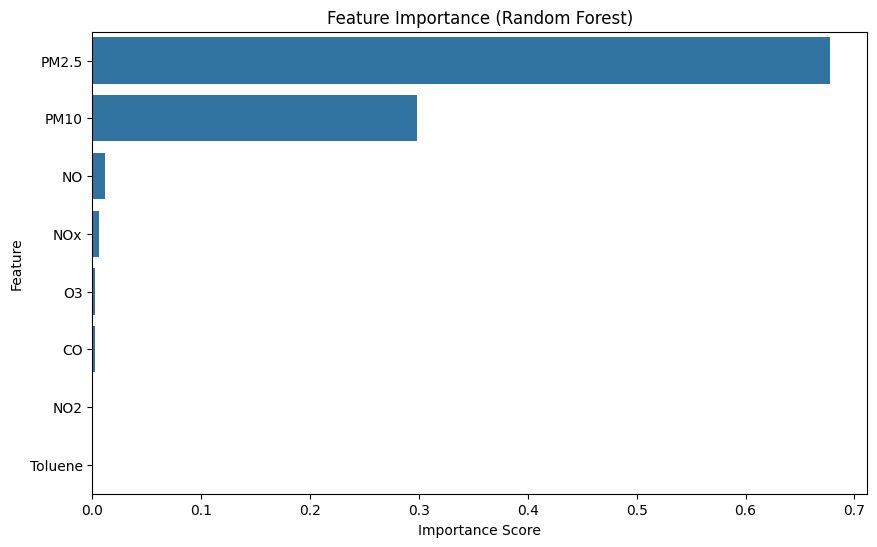

   Feature  Importance
0    PM2.5    0.677940
1     PM10    0.298713
2       NO    0.011603
4      NOx    0.006345
6       O3    0.002470
5       CO    0.002248
3      NO2    0.000370
7  Toluene    0.000312


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
importance = rf_model.feature_importances_
feature_names = features_selected.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Print feature importance
print(importance_df)


---
choosing threshold on the basis of pre existing knowledge regarding correlation of AQI and pollutants


---

In [9]:
# Set a threshold for importance
threshold = 0.001
relevant_features = importance_df[importance_df['Importance'] >= threshold]['Feature'].tolist()

# Print relevant features
print("\nRelevant Features Selected:")
print(relevant_features)

# Update features with only relevant ones
features_relevant = features_selected[relevant_features]

# Train-test split with relevant features
X_train_relevant, X_test_relevant, y_train, y_test = train_test_split(
    features_relevant, target, test_size=0.2, random_state=42
)

# Retrain Random Forest with relevant features
rf_model_relevant = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_relevant.fit(X_train_relevant, y_train)

# Predict and evaluate
y_pred_relevant = rf_model_relevant.predict(X_test_relevant)

# Compute performance metrics
rmse_relevant = mean_squared_error(y_test, y_pred_relevant) ** 0.5  # RMSE
mae_relevant = mean_absolute_error(y_test, y_pred_relevant)         # MAE
mape_relevant = (abs((y_test - y_pred_relevant) / y_test).mean()) * 100  # MAPE
r2_relevant = r2_score(y_test, y_pred_relevant)                     # R²

# Print performance metrics
print(f"\nPerformance Metrics with Relevant Features:")
print(f"RMSE: {rmse_relevant:.4f}")
print(f"MAE: {mae_relevant:.4f}")
print(f"MAPE: {mape_relevant:.2f}%")
print(f"R-Squared: {r2_relevant:.4f}")


Relevant Features Selected:
['PM2.5', 'PM10', 'NO', 'NOx', 'O3', 'CO']

Performance Metrics with Relevant Features:
RMSE: 6.5904
MAE: 2.4028
MAPE: 1.21%
R-Squared: 0.9973




---
hence toluene and NO2 can be removed from consideration.

Relevant Features Selected:
['PM2.5', 'PM10', 'NO', 'NOx', 'O3', 'CO']



---

# 4. SVM (Support Vector Machine) Regressor:

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd


In [11]:
# Load the dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Remove Benzene from the dataset
features_selected = features.drop(columns=['Benzene'])

# Scale features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_selected)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)


In [12]:
# Train SVM Regressor
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_model.fit(X_train, y_train)


SVR()

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['linear', 'rbf']
}

# Perform GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Use the best model
svm_model_best = grid_search.best_estimator_


In [ ]:
# Predict on test data
y_pred = svm_model_best.predict(X_test)

# Compute performance metrics
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # RMSE
mae = mean_absolute_error(y_test, y_pred)        # MAE
mape = (abs((y_test - y_pred) / y_test).mean()) * 100  # MAPE
r2 = r2_score(y_test, y_pred)                    # R²

# Print performance metrics
print(f"\nPerformance Metrics (SVM Regressor with Best Parameters):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R-Squared: {r2:.4f}")


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv('scaled_for_sequences.csv')

# Prepare features and target variable
features = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'O3', 'Benzene', 'Toluene']]
target = data['AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize SVM with RBF kernel
svr_rbf = SVR(kernel='rbf', C=100, epsilon=1) # <--- taking values from the best parameter assessment

# Recursive Feature Elimination (Simulated)
feature_names = list(features.columns)
selected_features = feature_names[:]  # Start with all features
min_rmse = float('inf')
best_features = selected_features[:]

print("Starting Feature Selection...")
for i in range(len(feature_names), 0, -1):
    # Train the model on the current feature subset
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]

    svr_rbf.fit(X_train_subset, y_train)

    # Predict and calculate RMSE
    y_pred = svr_rbf.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)  # Compute MSE
    rmse = mse ** 0.5  # Calculate RMSE manually

    print(f"Features: {selected_features}, RMSE: {rmse}")

    # Update the best feature set
    if rmse < min_rmse:
        min_rmse = rmse
        best_features = selected_features[:]

    # Remove the least important feature (one at a time)
    if len(selected_features) > 1:
        feature_to_remove = selected_features.pop()

# Display the best feature set
print(f"Best Features: {best_features}")
print(f"Minimum RMSE: {min_rmse}")

# Train final SVM with the best feature set
final_X_train = X_train[best_features]
final_X_test = X_test[best_features]

svr_rbf.fit(final_X_train, y_train)
final_y_pred = svr_rbf.predict(final_X_test)
final_rmse = mean_squared_error(y_test, final_y_pred) ** 0.5  # Compute RMSE manually

print(f"Final RMSE with Best Features: {final_rmse}")


# Ablation study of TCN

---

Key hyperparameters are :

1. **Number of Residual Blocks**: Depth of the network, influencing the complexity of the learned features.
2. **Number of Filters per Layer**: Controls the model’s capacity to capture patterns.
3. **Kernel Size**: Size of the convolutional filter, affecting the receptive field.
4. **Dilation Rate**: Determines the expansion of the receptive field to model long-range dependencies. ( influences no. of residual blocks directly )
5. **Dropout Rate**: Helps prevent overfitting by randomly dropping connections.
6. **Learning Rate**: Step size for weight updates during training.
7. **Batch Size**: Number of samples processed before updating the model's parameters.
8. **Loss Function**: Objective to minimize, such as MSE, MAE, or Huber loss.

---

In [3]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load and preprocess data
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'
X = df[features].values
y = df[target].values

# Split dataset into train, validation, and test
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Reshape for TCN input: (samples, timesteps, features)
X_train_tcn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_tcn = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_tcn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(f"TCN Input Shapes - Train: {X_train_tcn.shape}, Validation: {X_val_tcn.shape}, Test: {X_test_tcn.shape}")


TCN Input Shapes - Train: (1379, 1, 6), Validation: (394, 1, 6), Test: (198, 1, 6)


In [5]:
!pip install --upgrade --force-reinstall tensorflow==2.15.0 tensorflow-addons==0.23.0


  Using cached tensorflow_addons-0.23.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
  Using cached typeguard-2.13.3-py3-none-any.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.7 MB/s eta 0:00:00
Using cached tensorflow_addons-0.23.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.6 MB/s eta 0:00:00
  

In [3]:
!pip uninstall -y keras
!pip install tensorflow-addons==0.23.0




Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 31.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [1]:
!pip install keras-tcn --no-deps


### Base Model Hyperparameters

1. **Number of Residual Blocks**: Determined implicitly by the dilation rates `[1, 2, 4, 8]`, representing 4 residual blocks.
2. **Number of Filters per Layer**: `32`, defining the feature extraction capacity.
3. **Kernel Size**: `3`, affecting the receptive field size.
4. **Dilation Rate**: `[1, 2, 4, 8]`, enabling modeling of long-range dependencies.
5. **Dropout Rate**: `0.2`, used to prevent overfitting.
6. **Learning Rate**: `0.01`, step size for the Adam optimizer.
7. **Loss Function**: Mean Squared Error (`'mse'`), suited for regression tasks.
8. **Batch Size**: `16`, determining the number of samples processed in one training iteration.





In [4]:
# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tcn import TCN  # TCN layer from keras-tcn package

# Define the Sequential model
model_tcn = Sequential()

# Add the TCN layer
model_tcn.add(
    TCN(
        input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),  # Shape: (timesteps, features)
        nb_filters=32,              # 2. Number of Filters per Layer (controls the depth of each Conv1D)
        kernel_size=3,              # 3. Kernel Size (how many time steps each filter covers)
        dilations=[1, 2, 4, 8],     # 4. Dilation Rates (controls the receptive field; 4 residual blocks)
        activation='relu',         # Activation function for non-linearity
        dropout_rate=0.2,          # 5. Dropout Rate (regularization to prevent overfitting)
        padding='causal',          # Ensures no information leakage from future to past
        return_sequences=False     # False since we only want the final output (not a sequence)
    )
)

# Add output layer
model_tcn.add(Dense(1))  # Regression output (1 unit)

# Compile the model
optimizer_tcn = Adam(learning_rate=0.01)  # 6. Learning Rate for the optimizer
model_tcn.compile(
    optimizer=optimizer_tcn,
    loss='mse',                         # 7. Loss Function: Mean Squared Error for regression
    metrics=['mae']                     # Metric: Mean Absolute Error
)

# Train the model
history_tcn = model_tcn.fit(
    X_train_tcn, y_train,               # Training data
    validation_data=(X_val_tcn, y_val),# Validation data for monitoring generalization
    epochs=20,                          # Number of training epochs (hyperparameter)
    batch_size=16,                      # 8. Batch Size for mini-batch gradient descent
    verbose=1                           # Verbosity level (1 = progress bar)
)


Epoch 1/20
87/87 [==============================] - 4s 9ms/step - loss: 36020.4492 - mae: 149.0360 - val_loss: 5053.4087 - val_mae: 61.8256
Epoch 2/20
87/87 [==============================] - 0s 5ms/step - loss: 10819.2178 - mae: 83.8962 - val_loss: 5352.5049 - val_mae: 64.8448
Epoch 3/20
87/87 [==============================] - 0s 5ms/step - loss: 8103.9253 - mae: 72.5275 - val_loss: 7579.2124 - val_mae: 72.9905
Epoch 4/20
87/87 [==============================] - 0s 5ms/step - loss: 7254.9448 - mae: 68.4579 - val_loss: 7785.9917 - val_mae: 72.2429
Epoch 5/20
87/87 [==============================] - 0s 5ms/step - loss: 6835.4160 - mae: 66.0929 - val_loss: 6116.6343 - val_mae: 66.3612
Epoch 6/20
87/87 [==============================] - 0s 5ms/step - loss: 4628.6079 - mae: 54.2309 - val_loss: 5387.9023 - val_mae: 65.6095
Epoch 7/20
87/87 [==============================] - 0s 5ms/step - loss: 4006.5151 - mae: 50.7138 - val_loss: 5725.9536 - val_mae: 66.3510
Epoch 8/20
87/87 [=============

#Number of Residual Blocks/dilution rate

**Residual Blocks = 2, dilution rate (1,2)**

In [6]:
model_tcn_2blocks = Sequential()
model_tcn_2blocks.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                          nb_filters=32,
                          kernel_size=3,
                          dilations=[1, 2],
                          activation='relu',
                          dropout_rate=0.2,
                          padding='causal',
                          return_sequences=False))
model_tcn_2blocks.add(Dense(1))
model_tcn_2blocks.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_tcn_2blocks = model_tcn_2blocks.fit(
    X_train_tcn, y_train,
    validation_data=(X_val_tcn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)



Epoch 1/20
87/87 [==============================] - 3s 10ms/step - loss: 43276.9883 - mae: 157.3080 - val_loss: 4731.8579 - val_mae: 60.8380
Epoch 2/20
87/87 [==============================] - 0s 3ms/step - loss: 8535.7617 - mae: 73.7670 - val_loss: 5791.3135 - val_mae: 67.9945
Epoch 3/20
87/87 [==============================] - 1s 6ms/step - loss: 7372.9282 - mae: 68.6897 - val_loss: 6270.2734 - val_mae: 68.9307
Epoch 4/20
87/87 [==============================] - 0s 4ms/step - loss: 5972.7520 - mae: 62.4104 - val_loss: 10056.0918 - val_mae: 82.1110
Epoch 5/20
87/87 [==============================] - 0s 3ms/step - loss: 5617.1602 - mae: 59.8809 - val_loss: 10762.9492 - val_mae: 87.0028
Epoch 6/20
87/87 [==============================] - 1s 7ms/step - loss: 5638.9858 - mae: 60.7450 - val_loss: 8903.8652 - val_mae: 77.3200
Epoch 7/20
87/87 [==============================] - 0s 3ms/step - loss: 5595.4302 - mae: 59.7195 - val_loss: 6678.6416 - val_mae: 68.6853
Epoch 8/20
87/87 [===========

**Residual Blocks = 4 ,dilution rate (1,2,4,8)**

In [7]:
model_tcn_4blocks = Sequential()
model_tcn_4blocks.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                          nb_filters=32,
                          kernel_size=3,
                          dilations=[1, 2, 4, 8],
                          activation='relu',
                          dropout_rate=0.2,
                          padding='causal',
                          return_sequences=False))
model_tcn_4blocks.add(Dense(1))
model_tcn_4blocks.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_tcn_4blocks = model_tcn_4blocks.fit(
    X_train_tcn, y_train,
    validation_data=(X_val_tcn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20
87/87 [==============================] - 5s 7ms/step - loss: 38956.1953 - mae: 155.2781 - val_loss: 5933.6865 - val_mae: 64.7265
Epoch 2/20
87/87 [==============================] - 0s 4ms/step - loss: 12864.6514 - mae: 90.0081 - val_loss: 5960.8970 - val_mae: 68.4911
Epoch 3/20
87/87 [==============================] - 0s 5ms/step - loss: 8108.3589 - mae: 72.6011 - val_loss: 6040.8906 - val_mae: 70.3768
Epoch 4/20
87/87 [==============================] - 0s 4ms/step - loss: 6863.4307 - mae: 66.8513 - val_loss: 10404.0205 - val_mae: 82.2245
Epoch 5/20
87/87 [==============================] - 0s 4ms/step - loss: 5996.3955 - mae: 62.0180 - val_loss: 9712.8193 - val_mae: 78.7321
Epoch 6/20
87/87 [==============================] - 0s 4ms/step - loss: 4837.9907 - mae: 55.7260 - val_loss: 5520.2441 - val_mae: 67.7794
Epoch 7/20
87/87 [==============================] - 0s 4ms/step - loss: 3470.4180 - mae: 46.8508 - val_loss: 6306.0811 - val_mae: 66.3790
Epoch 8/20
87/87 [============

**Residual Blocks= 6, dilution rate (1,2,4,8,16,32)**

In [8]:
model_tcn_6blocks = Sequential()
model_tcn_6blocks.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                          nb_filters=32,
                          kernel_size=3,
                          dilations=[1, 2, 4, 8, 16, 32],
                          activation='relu',
                          dropout_rate=0.2,
                          padding='causal',
                          return_sequences=False))
model_tcn_6blocks.add(Dense(1))
model_tcn_6blocks.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_tcn_6blocks = model_tcn_6blocks.fit(
    X_train_tcn, y_train,
    validation_data=(X_val_tcn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20
87/87 [==============================] - 4s 12ms/step - loss: 31093.8711 - mae: 136.5410 - val_loss: 4398.4771 - val_mae: 57.5844
Epoch 2/20
87/87 [==============================] - 1s 8ms/step - loss: 10543.0518 - mae: 83.1503 - val_loss: 5940.6719 - val_mae: 69.8962
Epoch 3/20
87/87 [==============================] - 1s 7ms/step - loss: 8345.2100 - mae: 73.2743 - val_loss: 6340.3057 - val_mae: 71.1794
Epoch 4/20
87/87 [==============================] - 1s 7ms/step - loss: 6090.5591 - mae: 62.5999 - val_loss: 6517.7231 - val_mae: 73.7275
Epoch 5/20
87/87 [==============================] - 1s 9ms/step - loss: 4503.2871 - mae: 53.0980 - val_loss: 5800.8052 - val_mae: 69.6953
Epoch 6/20
87/87 [==============================] - 1s 11ms/step - loss: 3726.0469 - mae: 48.6323 - val_loss: 6002.7690 - val_mae: 69.6952
Epoch 7/20
87/87 [==============================] - 1s 12ms/step - loss: 3054.7300 - mae: 44.2054 - val_loss: 4558.9785 - val_mae: 61.2754
Epoch 8/20
87/87 [==========

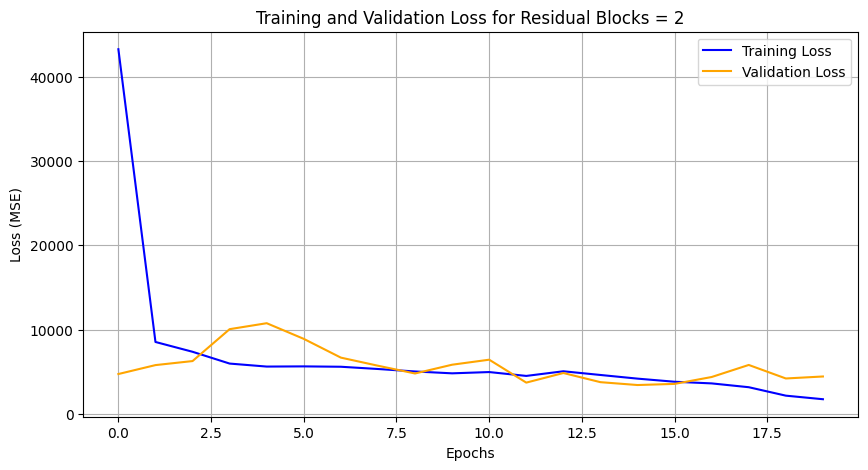

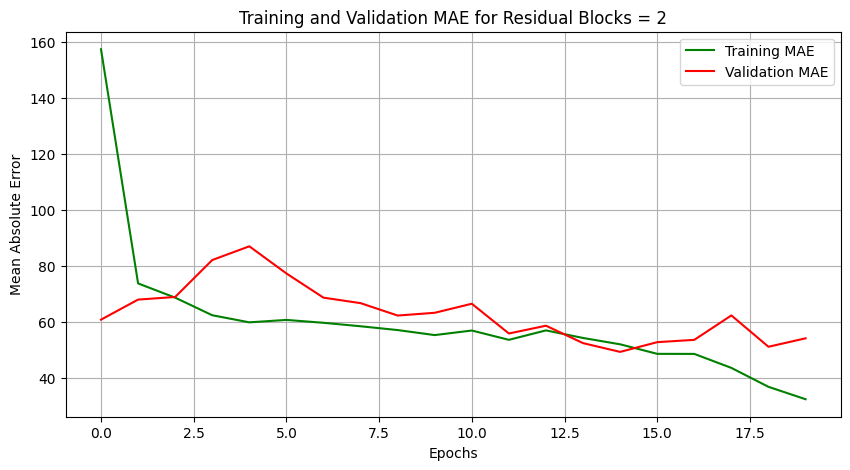

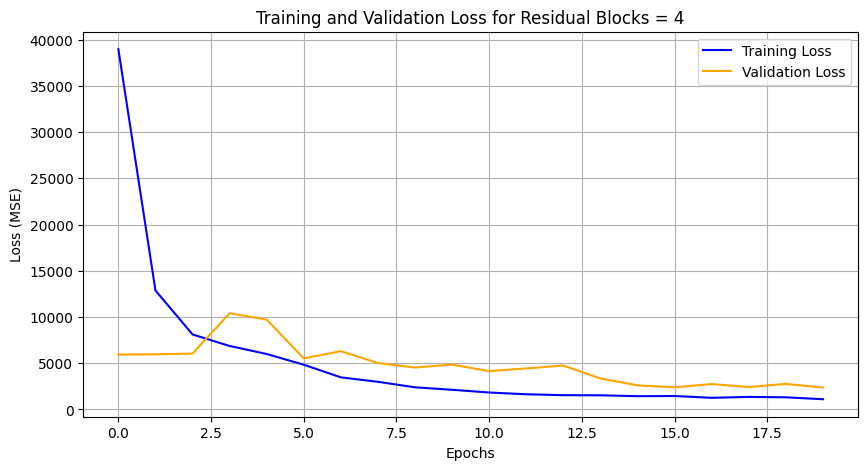

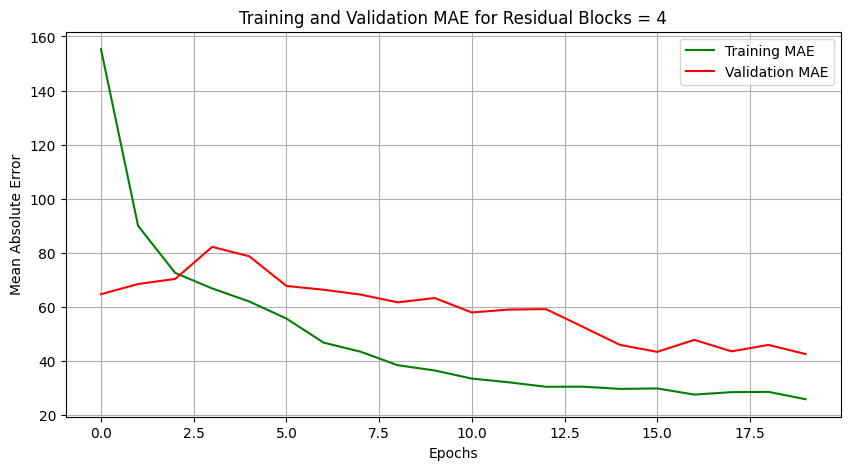

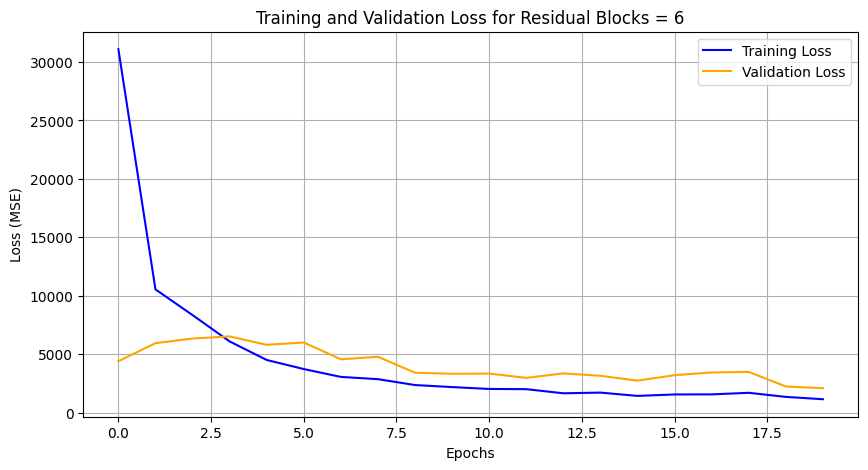

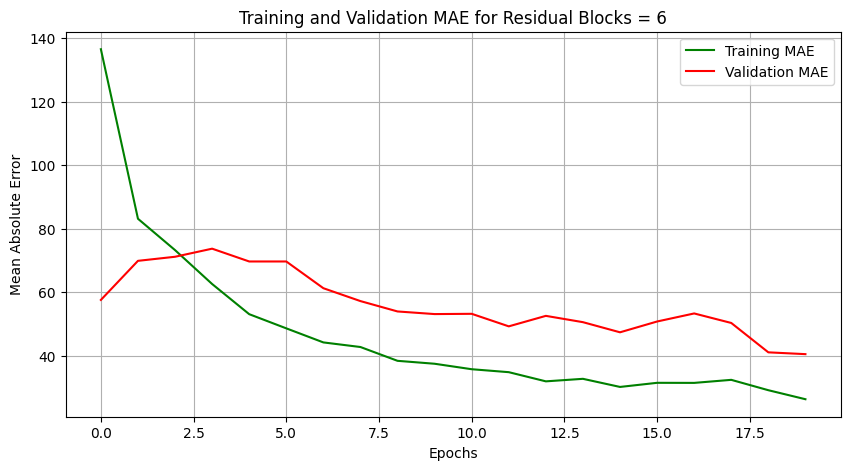

In [9]:
import matplotlib.pyplot as plt

# Histories and corresponding number of residual blocks
residual_block_histories = [history_tcn_2blocks, history_tcn_4blocks, history_tcn_6blocks]
num_blocks = [2, 4, 6]

for history, blocks in zip(residual_block_histories, num_blocks):
    # Plot: Loss (Training + Validation)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for Residual Blocks = {blocks}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE if available
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for Residual Blocks = {blocks}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for Residual Blocks = {blocks}.")



In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate TCN models with different residual blocks
evaluate_model(model_tcn_2blocks, X_test_tcn, y_test, name="TCN Model (2 Residual Blocks)")
evaluate_model(model_tcn_4blocks, X_test_tcn, y_test, name="TCN Model (4 Residual Blocks)")
evaluate_model(model_tcn_6blocks, X_test_tcn, y_test, name="TCN Model (6 Residual Blocks)")



7/7 [==============================] - 0s 2ms/step
📊 TCN Model (2 Residual Blocks) Metrics:
 - R²:   0.5952
 - RMSE: 68.6411
 - MAE:  53.6948
 - MAPE: 38.07%

7/7 [==============================] - 0s 2ms/step
📊 TCN Model (4 Residual Blocks) Metrics:
 - R²:   0.7695
 - RMSE: 51.7994
 - MAE:  40.4866
 - MAPE: 26.59%

7/7 [==============================] - 0s 3ms/step
📊 TCN Model (6 Residual Blocks) Metrics:
 - R²:   0.7953
 - RMSE: 48.8101
 - MAE:  37.8261
 - MAPE: 22.14%



**Hence metrics for 6 residual blocks TCN is the better one. So final model will have residual blocks =6.**

# number of filters per layer

**filters = 16**

In [17]:
model_tcn_16filters = Sequential()
model_tcn_16filters.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                            nb_filters=16,
                            kernel_size=3,
                            dilations=[1, 2, 4, 8, 16, 32],
                            activation='relu',
                            dropout_rate=0.2,
                            padding='causal',
                            return_sequences=False))
model_tcn_16filters.add(Dense(1))
model_tcn_16filters.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_tcn_16filters = model_tcn_16filters.fit(
    X_train_tcn, y_train,
    validation_data=(X_val_tcn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
87/87 [==============================] - 5s 11ms/step - loss: 48394.4805 - mae: 175.3429 - val_loss: 6357.8242 - val_mae: 72.3305
Epoch 2/20
87/87 [==============================] - 1s 6ms/step - loss: 12409.7881 - mae: 90.1960 - val_loss: 7013.8418 - val_mae: 74.9612
Epoch 3/20
87/87 [==============================] - 1s 7ms/step - loss: 9315.0195 - mae: 77.8402 - val_loss: 8326.9580 - val_mae: 79.5698
Epoch 4/20
87/87 [==============================] - 1s 10ms/step - loss: 8049.1318 - mae: 71.7967 - val_loss: 7918.1953 - val_mae: 79.8949
Epoch 5/20
87/87 [==============================] - 1s 9ms/step - loss: 6027.6338 - mae: 62.4472 - val_loss: 8061.3130 - val_mae: 78.1393
Epoch 6/20
87/87 [==============================] - 1s 10ms/step - loss: 6507.0078 - mae: 64.3752 - val_loss: 8222.8291 - val_mae: 78.4318
Epoch 7/20
87/87 [==============================] - 1s 9ms/step - loss: 5149.4077 - mae: 57.4592 - val_loss: 7577.6250 - val_mae: 77.6380
Epoch 8/20
87/87 [==========

**filters = 64**

In [19]:
model_tcn_64filters = Sequential()
model_tcn_64filters.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                            nb_filters=64,
                            kernel_size=3,
                             dilations=[1, 2, 4, 8, 16, 32],
                            activation='relu',
                            dropout_rate=0.2,
                            padding='causal',
                            return_sequences=False))
model_tcn_64filters.add(Dense(1))
model_tcn_64filters.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_tcn_64filters = model_tcn_64filters.fit(
    X_train_tcn, y_train,
    validation_data=(X_val_tcn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20
87/87 [==============================] - 5s 16ms/step - loss: 58271.7344 - mae: 188.3716 - val_loss: 3619.9705 - val_mae: 53.3686
Epoch 2/20
87/87 [==============================] - 1s 12ms/step - loss: 9722.5107 - mae: 79.1315 - val_loss: 5225.4810 - val_mae: 65.4510
Epoch 3/20
87/87 [==============================] - 1s 13ms/step - loss: 6567.0688 - mae: 65.3755 - val_loss: 4497.3843 - val_mae: 60.9232
Epoch 4/20
87/87 [==============================] - 2s 19ms/step - loss: 4611.3823 - mae: 54.3532 - val_loss: 4624.3086 - val_mae: 62.0932
Epoch 5/20
87/87 [==============================] - 3s 30ms/step - loss: 3571.8892 - mae: 47.8647 - val_loss: 5728.1562 - val_mae: 66.6884
Epoch 6/20
87/87 [==============================] - 1s 16ms/step - loss: 3260.2729 - mae: 45.8911 - val_loss: 5236.5283 - val_mae: 65.5305
Epoch 7/20
87/87 [==============================] - 1s 12ms/step - loss: 2730.3992 - mae: 41.7467 - val_loss: 4314.9326 - val_mae: 60.6334
Epoch 8/20
87/87 [=======

**filters = 128**

In [20]:
model_tcn_128filters = Sequential()
model_tcn_128filters.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                             nb_filters=128,
                             kernel_size=3,
                             dilations=[1, 2, 4, 8, 16, 32],
                             activation='relu',
                             dropout_rate=0.2,
                             padding='causal',
                             return_sequences=False))
model_tcn_128filters.add(Dense(1))
model_tcn_128filters.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_tcn_128filters = model_tcn_128filters.fit(
    X_train_tcn, y_train,
    validation_data=(X_val_tcn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
87/87 [==============================] - 6s 27ms/step - loss: 21320.1465 - mae: 105.5928 - val_loss: 4607.9575 - val_mae: 58.3756
Epoch 2/20
87/87 [==============================] - 2s 22ms/step - loss: 6527.4053 - mae: 65.0293 - val_loss: 9477.9609 - val_mae: 83.5408
Epoch 3/20
87/87 [==============================] - 2s 21ms/step - loss: 3786.3057 - mae: 50.1329 - val_loss: 5346.4277 - val_mae: 62.8909
Epoch 4/20
87/87 [==============================] - 2s 20ms/step - loss: 2723.5483 - mae: 42.0535 - val_loss: 6717.9941 - val_mae: 67.3798
Epoch 5/20
87/87 [==============================] - 3s 30ms/step - loss: 2029.6512 - mae: 35.9422 - val_loss: 4074.1677 - val_mae: 57.4055
Epoch 6/20
87/87 [==============================] - 2s 25ms/step - loss: 1821.2440 - mae: 33.9156 - val_loss: 4741.7231 - val_mae: 61.6610
Epoch 7/20
87/87 [==============================] - 2s 22ms/step - loss: 1468.2458 - mae: 30.8798 - val_loss: 6731.9214 - val_mae: 67.9432
Epoch 8/20
87/87 [=======

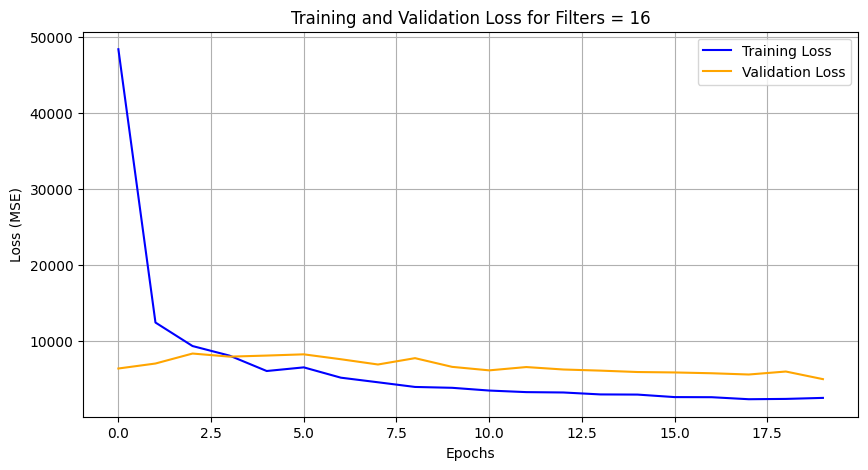

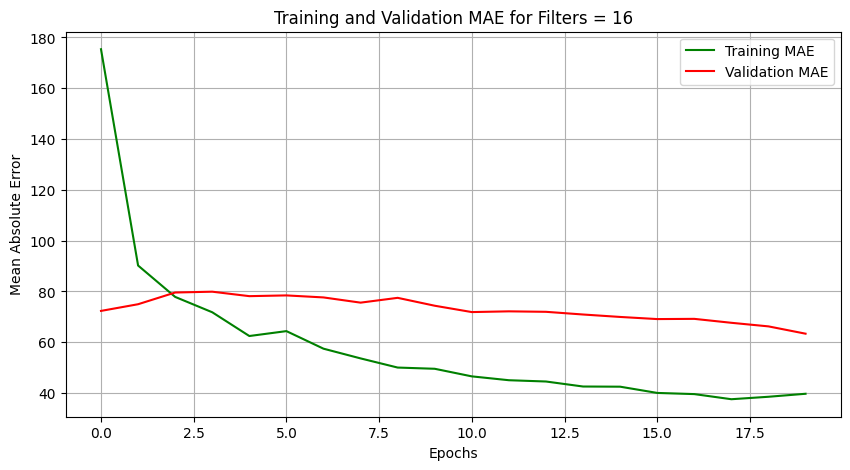

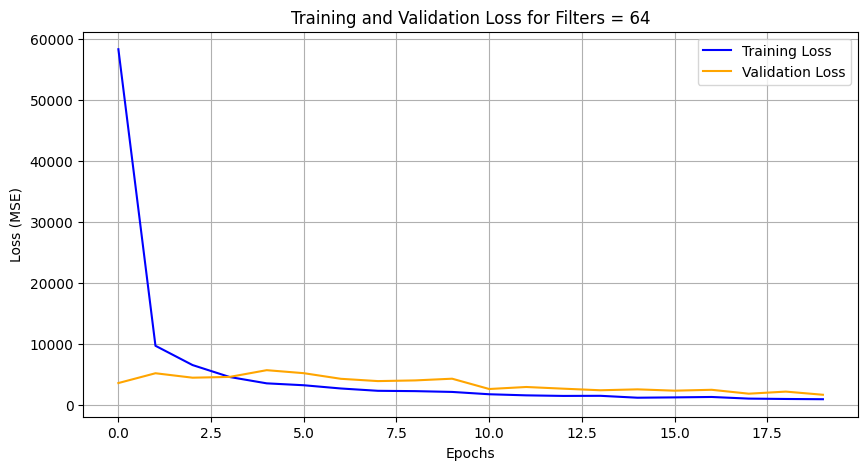

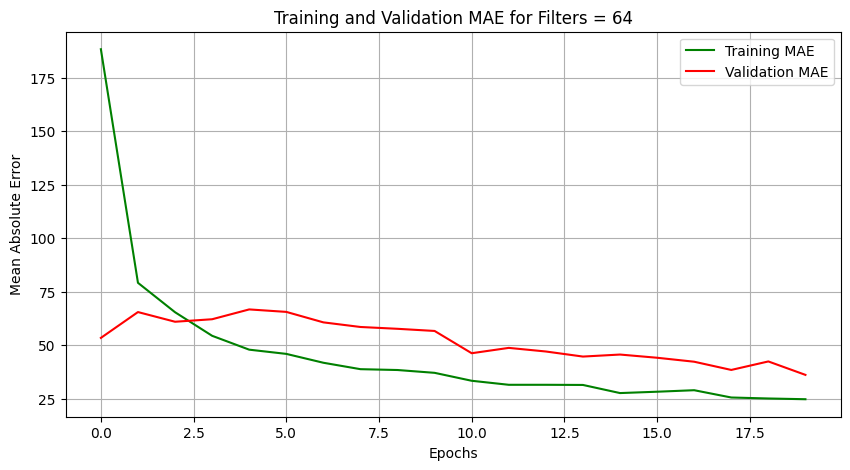

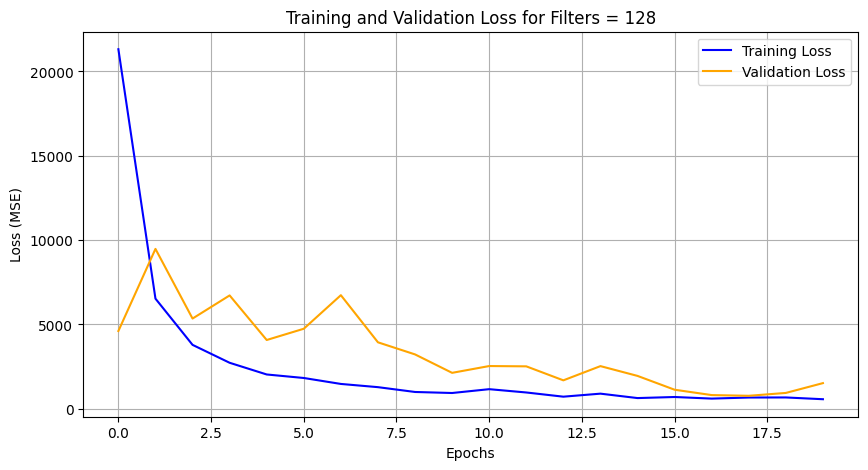

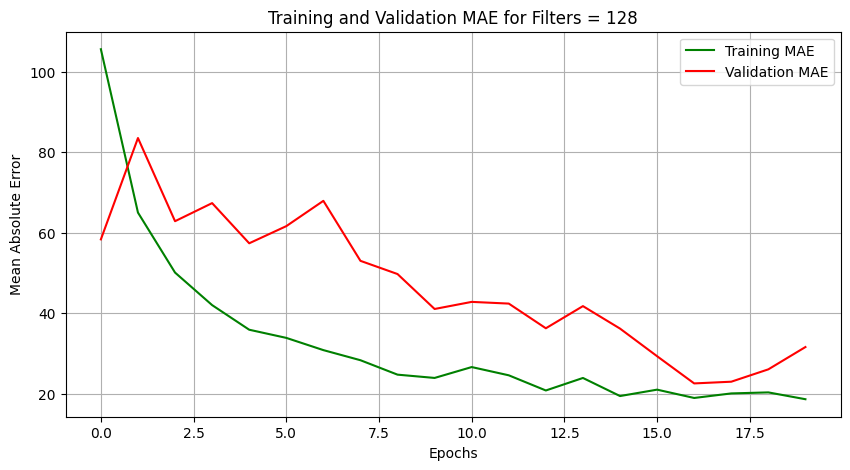

In [21]:
import matplotlib.pyplot as plt

# Histories and filter counts
filter_histories = [history_tcn_16filters, history_tcn_64filters, history_tcn_128filters]
filter_counts = [16, 64, 128]

for history, filters in zip(filter_histories, filter_counts):
    # Plot: Loss (Training + Validation)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for Filters = {filters}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE (if available)
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for Filters = {filters}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for Filters = {filters}.")


In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate TCN models with different filter counts
evaluate_model(model_tcn_16filters, X_test_tcn, y_test, name="TCN Model (16 Filters)")
evaluate_model(model_tcn_64filters, X_test_tcn, y_test, name="TCN Model (64 Filters)")
evaluate_model(model_tcn_128filters, X_test_tcn, y_test, name="TCN Model (128 Filters)")


7/7 [==============================] - 0s 3ms/step
📊 TCN Model (16 Filters) Metrics:
 - R²:   0.6051
 - RMSE: 67.7999
 - MAE:  58.6424
 - MAPE: 36.60%

7/7 [==============================] - 0s 4ms/step
📊 TCN Model (64 Filters) Metrics:
 - R²:   0.8441
 - RMSE: 42.5957
 - MAE:  30.2542
 - MAPE: 17.77%

7/7 [==============================] - 0s 7ms/step
📊 TCN Model (128 Filters) Metrics:
 - R²:   0.8035
 - RMSE: 47.8235
 - MAE:  30.5402
 - MAPE: 20.93%



** 64 filters is the best option.**

# kernal size

**kernal size = 2**

In [23]:
model_tcn_kernel2 = Sequential()
model_tcn_kernel2.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                          nb_filters=64,
                          kernel_size=2,
                          dilations=[1, 2, 4, 8, 16, 32],
                          activation='relu',
                          dropout_rate=0.2,
                          padding='causal',
                          return_sequences=False))
model_tcn_kernel2.add(Dense(1))
model_tcn_kernel2.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_tcn_kernel2 = model_tcn_kernel2.fit(
    X_train_tcn, y_train,
    validation_data=(X_val_tcn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
87/87 [==============================] - 6s 14ms/step - loss: 20087.4043 - mae: 108.8201 - val_loss: 3442.2212 - val_mae: 52.4011
Epoch 2/20
87/87 [==============================] - 1s 10ms/step - loss: 7801.9282 - mae: 71.4573 - val_loss: 4587.7046 - val_mae: 60.8845
Epoch 3/20
87/87 [==============================] - 1s 9ms/step - loss: 5541.8545 - mae: 59.0047 - val_loss: 6210.2100 - val_mae: 67.9230
Epoch 4/20
87/87 [==============================] - 1s 10ms/step - loss: 4142.4600 - mae: 51.6867 - val_loss: 5171.2168 - val_mae: 65.8487
Epoch 5/20
87/87 [==============================] - 2s 18ms/step - loss: 4987.9272 - mae: 56.6812 - val_loss: 5547.0254 - val_mae: 68.2747
Epoch 6/20
87/87 [==============================] - 2s 17ms/step - loss: 2748.7046 - mae: 41.5910 - val_loss: 5062.0991 - val_mae: 63.9957
Epoch 7/20
87/87 [==============================] - 2s 19ms/step - loss: 2593.3074 - mae: 40.7245 - val_loss: 4749.5996 - val_mae: 63.4374
Epoch 8/20
87/87 [========

**kernal size = 3**

In [24]:
model_tcn_kernel3 = Sequential()
model_tcn_kernel3.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                          nb_filters=64,
                          kernel_size=3,
                          dilations=[1, 2, 4, 8, 16, 32],
                          activation='relu',
                          dropout_rate=0.2,
                          padding='causal',
                          return_sequences=False))
model_tcn_kernel3.add(Dense(1))
model_tcn_kernel3.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_tcn_kernel3 = model_tcn_kernel3.fit(
    X_train_tcn, y_train,
    validation_data=(X_val_tcn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
87/87 [==============================] - 7s 29ms/step - loss: 66888.1562 - mae: 205.1450 - val_loss: 3675.2839 - val_mae: 53.1768
Epoch 2/20
87/87 [==============================] - 2s 28ms/step - loss: 11266.9297 - mae: 85.7784 - val_loss: 5560.3467 - val_mae: 65.1208
Epoch 3/20
87/87 [==============================] - 2s 18ms/step - loss: 6609.9131 - mae: 66.4557 - val_loss: 6436.8672 - val_mae: 67.7434
Epoch 4/20
87/87 [==============================] - 2s 20ms/step - loss: 5769.6372 - mae: 60.8381 - val_loss: 5861.8467 - val_mae: 67.4443
Epoch 5/20
87/87 [==============================] - 2s 19ms/step - loss: 4673.3369 - mae: 54.8522 - val_loss: 5049.9653 - val_mae: 65.5799
Epoch 6/20
87/87 [==============================] - 2s 19ms/step - loss: 3698.9636 - mae: 48.6936 - val_loss: 5181.5420 - val_mae: 64.5257
Epoch 7/20
87/87 [==============================] - 2s 19ms/step - loss: 2902.4656 - mae: 42.6804 - val_loss: 4728.9160 - val_mae: 64.1114
Epoch 8/20
87/87 [======

**kernal size = 5**



In [25]:
model_tcn_kernel5 = Sequential()
model_tcn_kernel5.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                          nb_filters=64,
                          kernel_size=5,
                          dilations=[1, 2, 4, 8, 16, 32],
                          activation='relu',
                          dropout_rate=0.2,
                          padding='causal',
                          return_sequences=False))
model_tcn_kernel5.add(Dense(1))
model_tcn_kernel5.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_tcn_kernel5 = model_tcn_kernel5.fit(
    X_train_tcn, y_train,
    validation_data=(X_val_tcn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
87/87 [==============================] - 5s 18ms/step - loss: 20644.6113 - mae: 106.2764 - val_loss: 4898.6987 - val_mae: 59.1726
Epoch 2/20
87/87 [==============================] - 1s 14ms/step - loss: 7345.3247 - mae: 68.6096 - val_loss: 5249.8516 - val_mae: 63.3346
Epoch 3/20
87/87 [==============================] - 1s 15ms/step - loss: 4195.4487 - mae: 51.3291 - val_loss: 7674.6343 - val_mae: 71.0563
Epoch 4/20
87/87 [==============================] - 1s 14ms/step - loss: 2801.3762 - mae: 43.0921 - val_loss: 4044.5413 - val_mae: 58.6624
Epoch 5/20
87/87 [==============================] - 2s 20ms/step - loss: 2846.4185 - mae: 42.8874 - val_loss: 4995.2803 - val_mae: 62.2698
Epoch 6/20
87/87 [==============================] - 2s 21ms/step - loss: 2164.2373 - mae: 36.9016 - val_loss: 3216.8101 - val_mae: 50.5028
Epoch 7/20
87/87 [==============================] - 1s 15ms/step - loss: 1378.2710 - mae: 29.5000 - val_loss: 4470.3330 - val_mae: 55.3821
Epoch 8/20
87/87 [=======

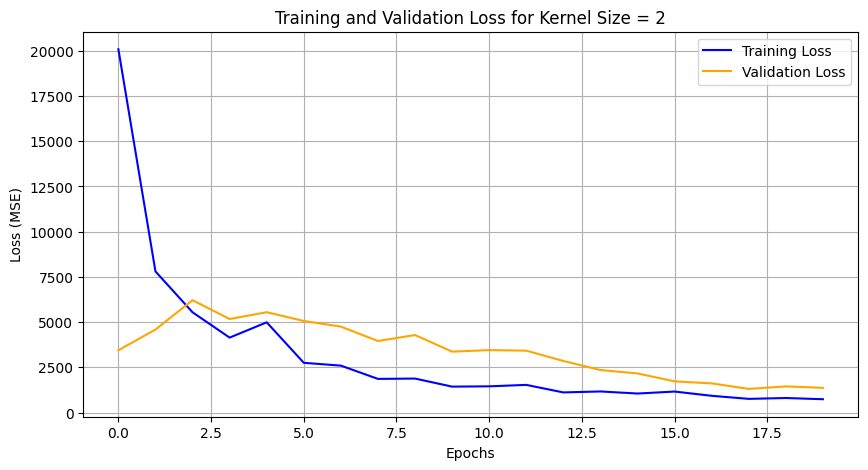

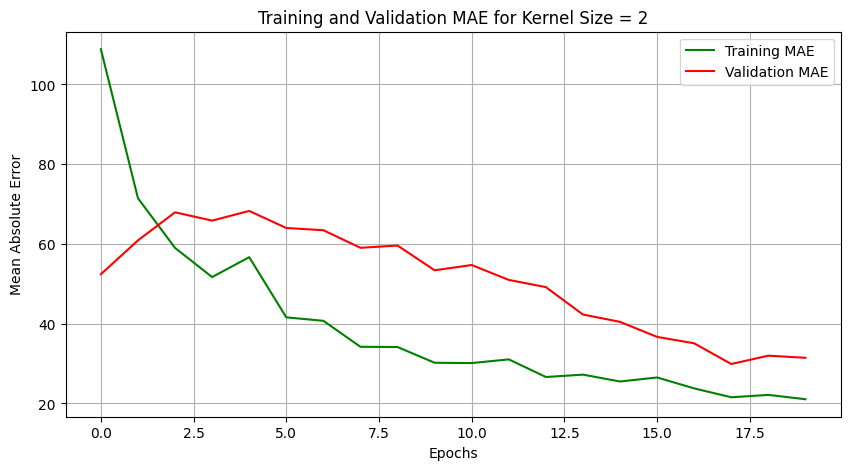

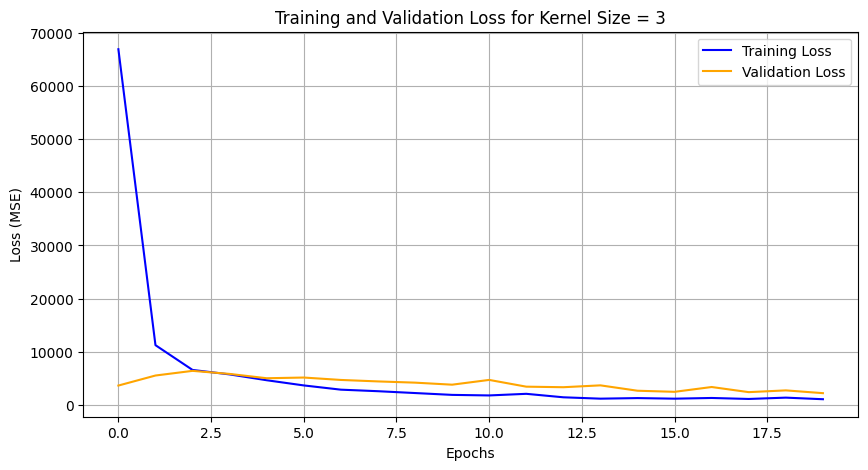

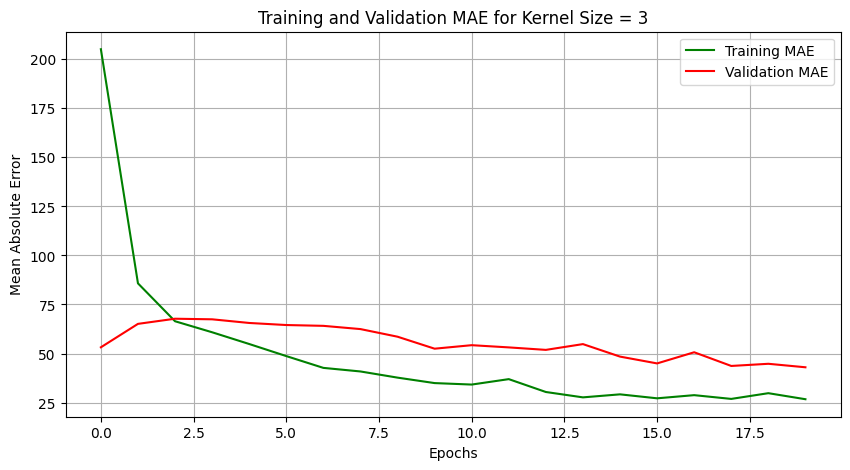

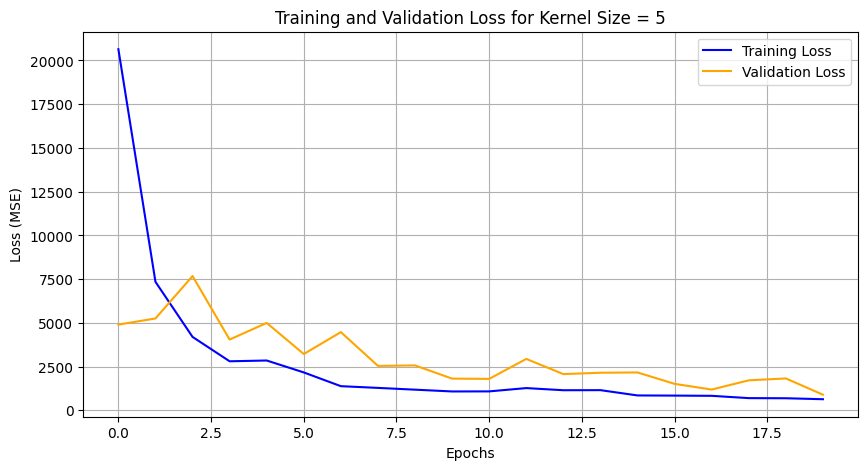

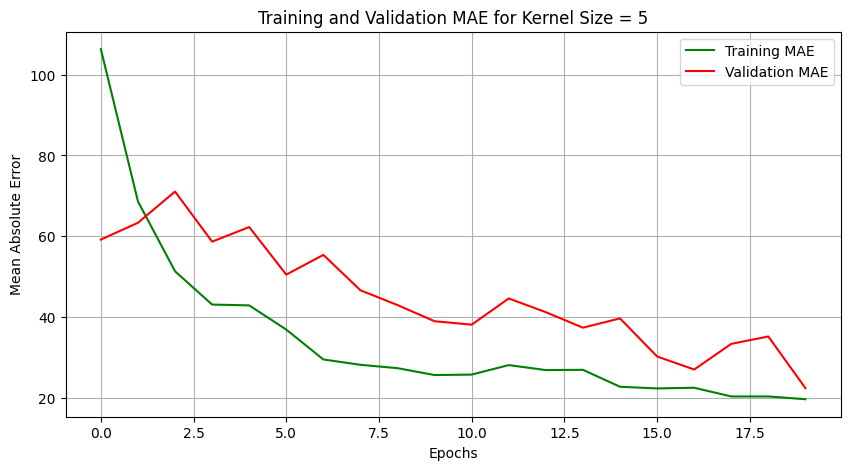

In [26]:
import matplotlib.pyplot as plt

# Histories and corresponding kernel sizes
kernel_histories = [history_tcn_kernel2, history_tcn_kernel3, history_tcn_kernel5]
kernel_sizes = [2, 3, 5]

for history, k in zip(kernel_histories, kernel_sizes):
    # Plot: Loss (Training + Validation)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for Kernel Size = {k}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE if tracked
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for Kernel Size = {k}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for Kernel Size = {k}.")


In [27]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate TCN models with different kernel sizes
evaluate_model(model_tcn_kernel2, X_test_tcn, y_test, name="TCN Model (Kernel Size = 2)")
evaluate_model(model_tcn_kernel3, X_test_tcn, y_test, name="TCN Model (Kernel Size = 3)")
evaluate_model(model_tcn_kernel5, X_test_tcn, y_test, name="TCN Model (Kernel Size = 5)")


7/7 [==============================] - 0s 3ms/step
📊 TCN Model (Kernel Size = 2) Metrics:
 - R²:   0.8528
 - RMSE: 41.3888
 - MAE:  27.7856
 - MAPE: 16.55%

7/7 [==============================] - 0s 5ms/step
📊 TCN Model (Kernel Size = 3) Metrics:
 - R²:   0.8027
 - RMSE: 47.9198
 - MAE:  37.5794
 - MAPE: 22.41%

7/7 [==============================] - 0s 5ms/step
📊 TCN Model (Kernel Size = 5) Metrics:
 - R²:   0.8712
 - RMSE: 38.7235
 - MAE:  19.7579
 - MAPE: 14.26%



**kernel size 5 works best.**

#learning rate ( using adam )

**learning rate =0.1**

In [7]:
model_lr_01 = Sequential()
model_lr_01.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                    nb_filters=64,
                    kernel_size=5,
                    dilations=[1, 2, 4, 8, 16, 32],
                    activation='relu',
                    dropout_rate=0.2,
                    padding='causal',
                    return_sequences=False))
model_lr_01.add(Dense(1))
model_lr_01.compile(optimizer=Adam(learning_rate=0.1), loss='mse', metrics=['mae'])

history_lr_01 = model_lr_01.fit(X_train_tcn, y_train,
                                validation_data=(X_val_tcn, y_val),
                                epochs=20, batch_size=16, verbose=1)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 36066600.0000 - mae: 1527.8552 - val_loss: 22291.4629 - val_mae: 122.3288
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 27940.9453 - mae: 135.1893 - val_loss: 24682.8320 - val_mae: 130.7031
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 20961.5566 - mae: 117.3545 - val_loss: 21213.4043 - val_mae: 123.0998
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 18737.5449 - mae: 110.1469 - val_loss: 28273.3223 - val_mae: 139.9728
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 16316.5059 - mae: 101.5426 - val_loss: 23106.5586 - val_mae: 126.1468
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 15436.9697 - mae: 99.8543 - val_loss: 24272.7715 - val_mae: 128.4088
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 14533.7910 - mae: 96.4407 - val_loss: 24492.1582 - val_mae: 128.7012
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 14385.8242 - mae: 94.6043 - val_loss

**learning rate =0.01**

In [8]:
model_lr_001 = Sequential()
model_lr_001.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                     nb_filters=64,
                     kernel_size=5,
                     dilations=[1, 2, 4, 8, 16, 32],
                     activation='relu',
                     dropout_rate=0.2,
                     padding='causal',
                     return_sequences=False))
model_lr_001.add(Dense(1))
model_lr_001.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_lr_001 = model_lr_001.fit(X_train_tcn, y_train,
                                  validation_data=(X_val_tcn, y_val),
                                  epochs=20, batch_size=16, verbose=1)



Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 38644.9922 - mae: 153.7233 - val_loss: 3872.2319 - val_mae: 54.4061
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7433.8560 - mae: 69.3461 - val_loss: 6813.3120 - val_mae: 68.5002
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5201.6387 - mae: 57.4589 - val_loss: 5566.3970 - val_mae: 67.8386
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 4877.5986 - mae: 56.9426 - val_loss: 5191.2949 - val_mae: 66.2525
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3654.6155 - mae: 48.7982 - val_loss: 4794.9233 - val_mae: 64.3077
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2168.9873 - mae: 37.9762 - val_loss: 4165.6162 - val_mae: 60.1535
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2477.9382 - mae: 40.4673 - val_loss: 3305.0342 - val_mae: 52.9363
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1389.7013 - mae: 29.5906 - val_loss: 2717.9700 - val_mae: 49.27

**learning rate =0.001**

In [9]:
model_lr_0001 = Sequential()
model_lr_0001.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                      nb_filters=64,
                      kernel_size=5,
                      dilations=[1, 2, 4, 8, 16, 32],
                      activation='relu',
                      dropout_rate=0.2,
                      padding='causal',
                      return_sequences=False))
model_lr_0001.add(Dense(1))
model_lr_0001.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history_lr_0001 = model_lr_0001.fit(X_train_tcn, y_train,
                                    validation_data=(X_val_tcn, y_val),
                                    epochs=20, batch_size=16, verbose=1)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 101354.0312 - mae: 277.5105 - val_loss: 3605.9954 - val_mae: 46.1121
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 8465.7363 - mae: 74.9574 - val_loss: 4543.1338 - val_mae: 54.9721
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 8123.2666 - mae: 72.8758 - val_loss: 3546.5254 - val_mae: 53.2871
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6502.5488 - mae: 65.1118 - val_loss: 5544.6973 - val_mae: 62.4759
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 4974.3262 - mae: 57.4186 - val_loss: 4599.9336 - val_mae: 59.9050
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4239.9238 - mae: 52.8836 - val_loss: 4578.1353 - val_mae: 62.2671
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4220.9097 - mae: 52.8566 - val_loss: 4836.7188 - val_mae: 64.2213
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4020.2349 - mae: 51.2917 - val_loss: 4868.1914 - val_mae: 64.05

**learning rate =0.0005**

In [10]:
model_lr_0005 = Sequential()
model_lr_0005.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                      nb_filters=64,
                      kernel_size=5,
                      dilations=[1, 2, 4, 8, 16, 32],
                      activation='relu',
                      dropout_rate=0.2,
                      padding='causal',
                      return_sequences=False))
model_lr_0005.add(Dense(1))
model_lr_0005.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

history_lr_0005 = model_lr_0005.fit(X_train_tcn, y_train,
                                    validation_data=(X_val_tcn, y_val),
                                    epochs=20, batch_size=16, verbose=1)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 131978.1094 - mae: 337.0154 - val_loss: 6723.0049 - val_mae: 62.7829
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 10216.1670 - mae: 80.7710 - val_loss: 3564.9717 - val_mae: 48.2841
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7323.9502 - mae: 68.8132 - val_loss: 3240.8645 - val_mae: 49.3745
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7188.3135 - mae: 68.1618 - val_loss: 3706.4226 - val_mae: 53.3124
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 6176.3696 - mae: 63.0302 - val_loss: 3821.6221 - val_mae: 54.7863
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5680.9077 - mae: 61.1853 - val_loss: 3927.2190 - val_mae: 57.0337
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 5128.0708 - mae: 57.5407 - val_loss: 4478.1162 - val_mae: 60.4724
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4550.2891 - mae: 54.7354 - val_loss: 4303.1772 - val_mae: 60.

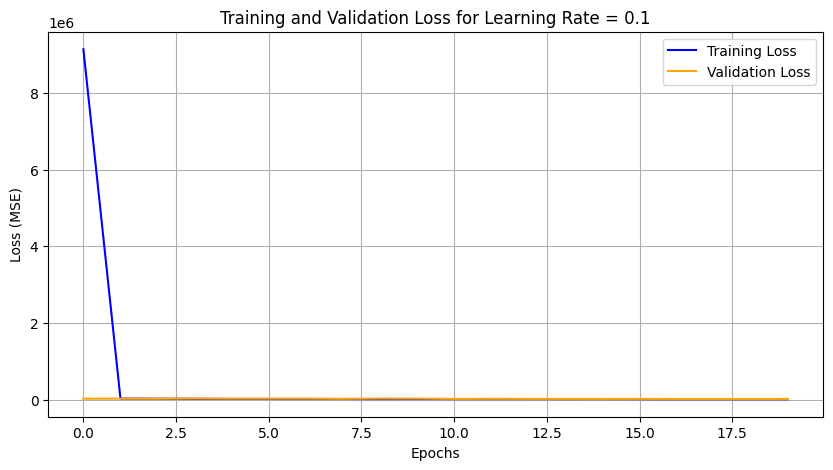

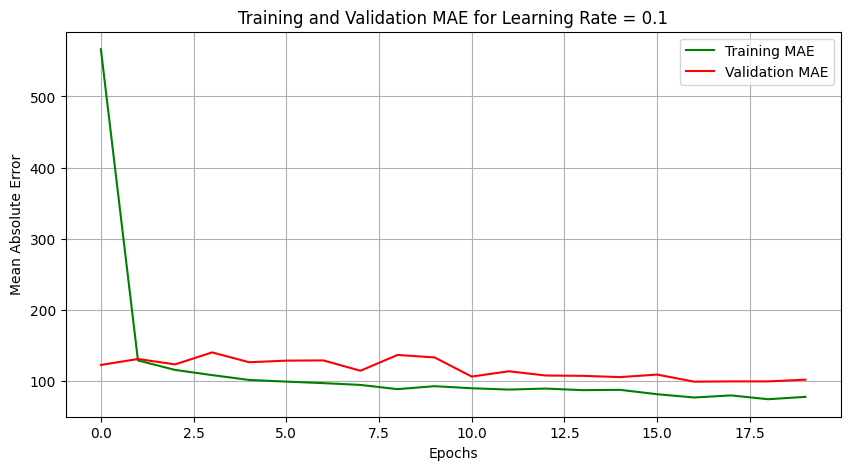

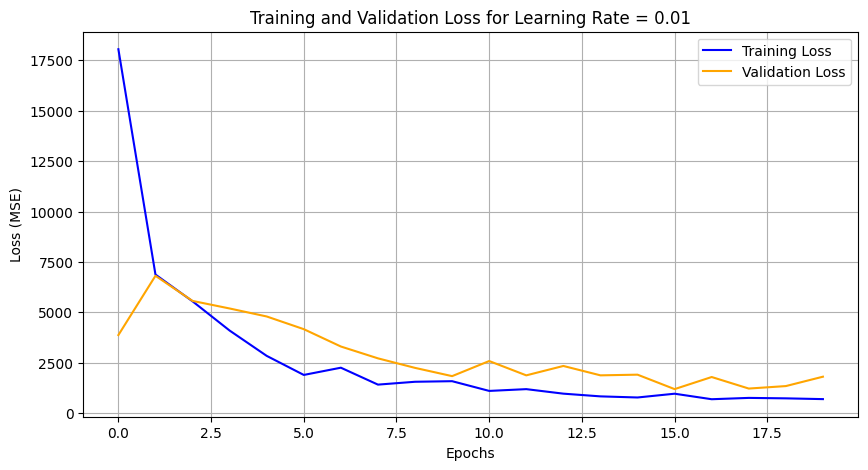

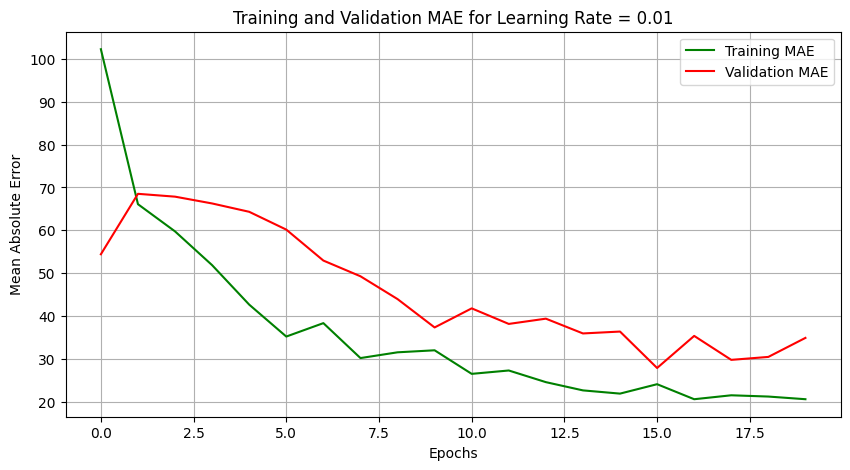

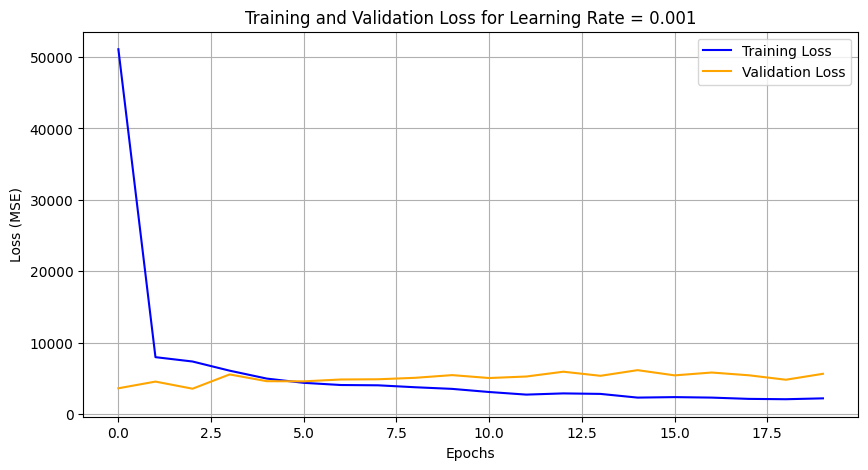

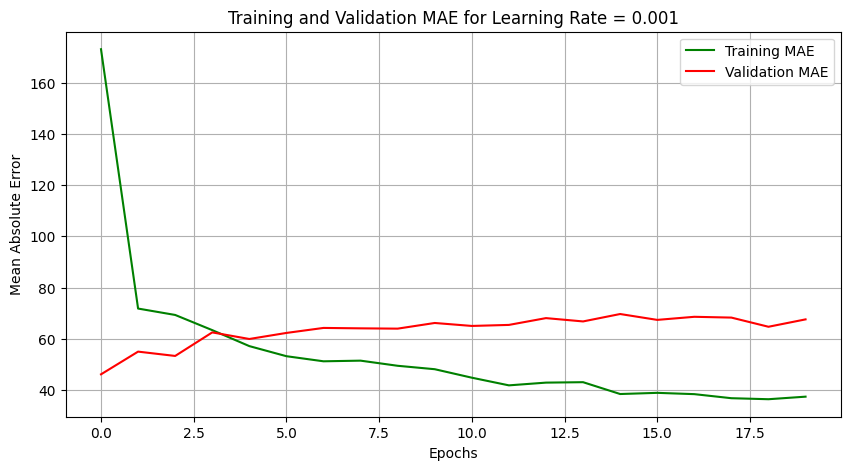

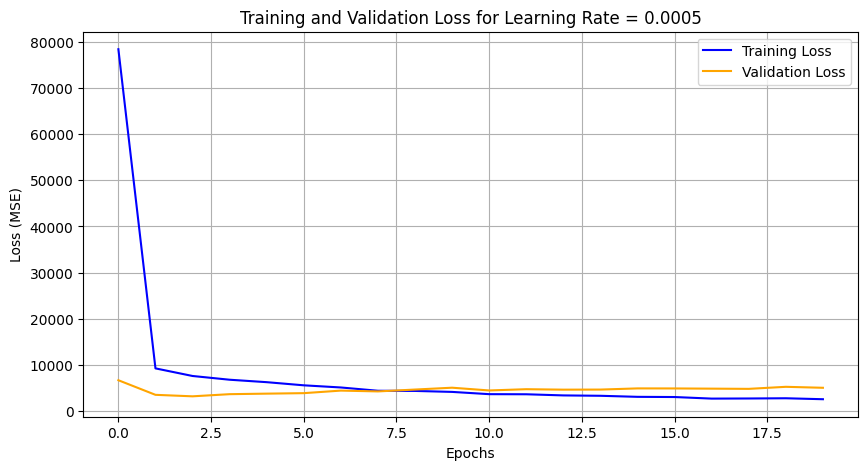

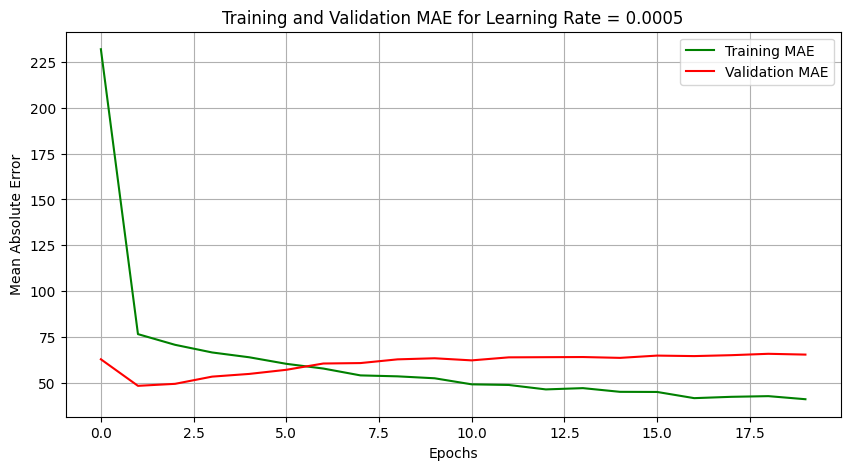

In [11]:
import matplotlib.pyplot as plt

# Histories and corresponding learning rates
lr_histories = [history_lr_01, history_lr_001, history_lr_0001, history_lr_0005]
learning_rates = [0.1, 0.01, 0.001, 0.0005]

for history, lr in zip(lr_histories, learning_rates):
    # Plot: Loss (Training + Validation)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for Learning Rate = {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE if tracked
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for Learning Rate = {lr}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for Learning Rate = {lr}.")


In [12]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate TCN models with different learning rates
evaluate_model(model_lr_01, X_test_tcn, y_test, name="TCN Model (Learning Rate = 0.1)")
evaluate_model(model_lr_001, X_test_tcn, y_test, name="TCN Model (Learning Rate = 0.01)")
evaluate_model(model_lr_0001, X_test_tcn, y_test, name="TCN Model (Learning Rate = 0.001)")
evaluate_model(model_lr_0005, X_test_tcn, y_test, name="TCN Model (Learning Rate = 0.0005)")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
📊 TCN Model (Learning Rate = 0.1) Metrics:
 - R²:   -0.2681
 - RMSE: 121.4986
 - MAE:  97.3966
 - MAPE: 70.83%

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step
📊 TCN Model (Learning Rate = 0.01) Metrics:
 - R²:   0.7867
 - RMSE: 49.8332
 - MAE:  33.4891
 - MAPE: 23.85%



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
📊 TCN Model (Learning Rate = 0.001) Metrics:
 - R²:   0.5566
 - RMSE: 71.8457
 - MAE:  62.6360
 - MAPE: 33.44%



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
📊 TCN Model (Learning Rate = 0.0005) Metrics:
 - R²:   0.5696
 - RMSE: 70.7845
 - MAE:  62.3855
 - MAPE: 33.75%



**adam with learning rate 0.01 works best**

#optimizers

**adam(0.01)**

In [13]:
model_opt_adam = Sequential()
model_opt_adam.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                       nb_filters=64,
                       kernel_size=5,
                       dilations=[1, 2, 4, 8, 16, 32],
                       activation='relu',
                       dropout_rate=0.2,
                       padding='causal',
                       return_sequences=False))
model_opt_adam.add(Dense(1))
model_opt_adam.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_opt_adam = model_opt_adam.fit(X_train_tcn, y_train,
                                      validation_data=(X_val_tcn, y_val),
                                      epochs=20, batch_size=16, verbose=1)



/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 43450.0391 - mae: 163.2398 - val_loss: 3224.9480 - val_mae: 50.2823
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 6444.6470 - mae: 64.7378 - val_loss: 6032.1357 - val_mae: 66.4497
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6059.1997 - mae: 62.3963 - val_loss: 5338.9937 - val_mae: 65.4700
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4000.8628 - mae: 50.6824 - val_loss: 5456.2656 - val_mae: 64.8463
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3438.5159 - mae: 47.1357 - val_loss: 4883.3193 - val_mae: 61.8904
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2624.2400 - mae: 41.8156 - val_loss: 5469.8052 - val_mae: 62.0932
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1969.7144 - mae: 35.8103 - val_loss: 3891.6028 - val_mae: 57.3941
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2495.4036 - mae: 40.8518 - val_loss: 3395.0422 - val_mae: 51.04

**SDG**

In [14]:
from tensorflow.keras.optimizers import SGD

model_opt_sgd = Sequential()
model_opt_sgd.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                      nb_filters=64,
                      kernel_size=5,
                      dilations=[1, 2, 4, 8, 16, 32],
                      activation='relu',
                      dropout_rate=0.2,
                      padding='causal',
                      return_sequences=False))
model_opt_sgd.add(Dense(1))

# SGD with smaller LR + gradient clipping
optimizer_sgd = SGD(learning_rate=0.0005, clipnorm=1.0)

model_opt_sgd.compile(optimizer=optimizer_sgd, loss='mse', metrics=['mae'])

history_opt_sgd = model_opt_sgd.fit(X_train_tcn, y_train,
                                    validation_data=(X_val_tcn, y_val),
                                    epochs=20,
                                    batch_size=16,
                                    verbose=1)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 168362.8906 - mae: 401.2481 - val_loss: 73111.3984 - val_mae: 237.1688
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 166280.3438 - mae: 398.0461 - val_loss: 72419.2578 - val_mae: 235.9415
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 166344.7656 - mae: 398.4760 - val_loss: 71526.4609 - val_mae: 234.3430
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 161644.2656 - mae: 392.9700 - val_loss: 70357.4766 - val_mae: 232.2219
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 160815.4688 - mae: 391.7111 - val_loss: 68808.5938 - val_mae: 229.3707
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 155847.1094 - mae: 385.4318 - val_loss: 66749.3828 - val_mae: 225.5153
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 148966.4844 - mae: 375.9152 - val_loss: 64026.6719 - val_mae: 220.3051
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 143077.7656 - mae: 368.2687 - v

**RMSProp**

In [15]:
from tensorflow.keras.optimizers import RMSprop

model_opt_rmsprop = Sequential()
model_opt_rmsprop.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                          nb_filters=64,
                          kernel_size=5,
                          dilations=[1, 2, 4, 8, 16, 32],
                          activation='relu',
                          dropout_rate=0.2,
                          padding='causal',
                          return_sequences=False))
model_opt_rmsprop.add(Dense(1))
model_opt_rmsprop.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

history_opt_rmsprop = model_opt_rmsprop.fit(X_train_tcn, y_train,
                                            validation_data=(X_val_tcn, y_val),
                                            epochs=20, batch_size=16, verbose=1)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 62314.4609 - mae: 197.4969 - val_loss: 2759.7754 - val_mae: 46.2803
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 9764.7520 - mae: 79.3267 - val_loss: 3728.9822 - val_mae: 50.9715
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 7727.7134 - mae: 71.8590 - val_loss: 3238.8779 - val_mae: 50.8792
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7856.5557 - mae: 69.8272 - val_loss: 9291.8428 - val_mae: 75.3970
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7271.7129 - mae: 69.3623 - val_loss: 4072.4448 - val_mae: 58.1201
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 7048.9058 - mae: 65.3516 - val_loss: 5874.5757 - val_mae: 65.6910
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 6016.1177 - mae: 62.8023 - val_loss: 4561.9951 - val_mae: 62.2293
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6091.6875 - mae: 62.9958 - val_loss: 4974.9370 - val_mae: 65.178

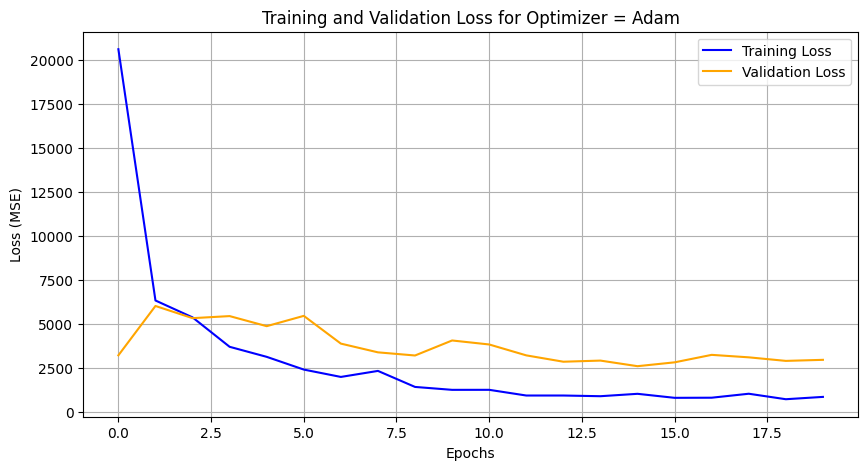

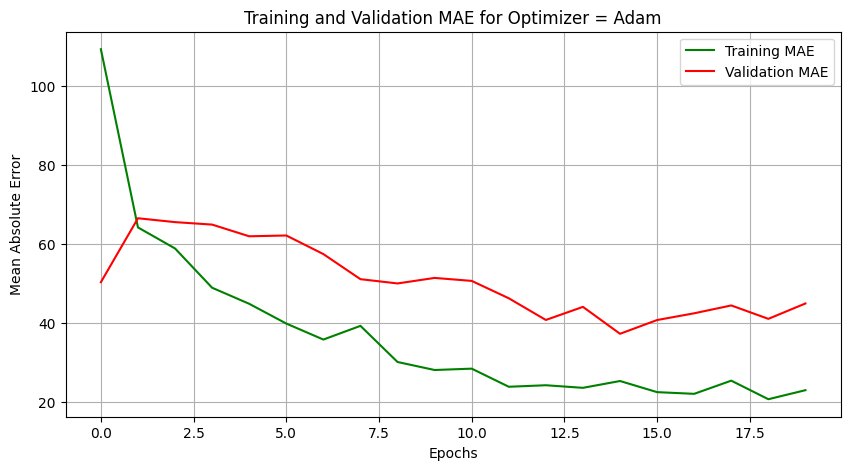

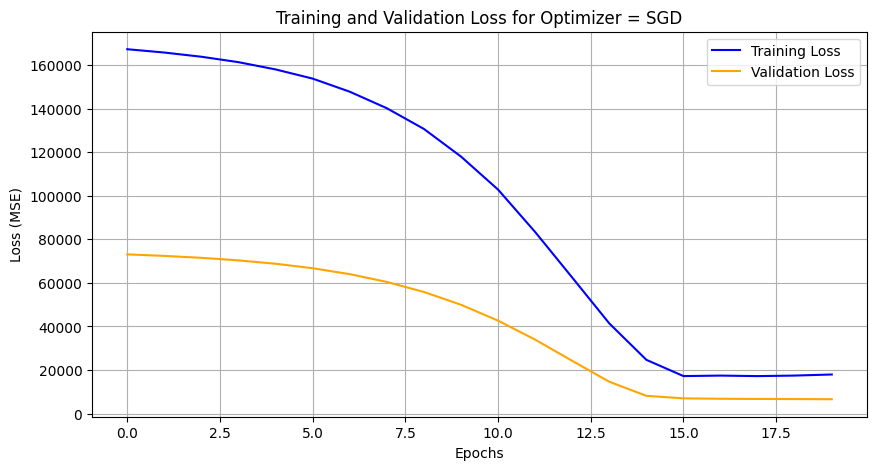

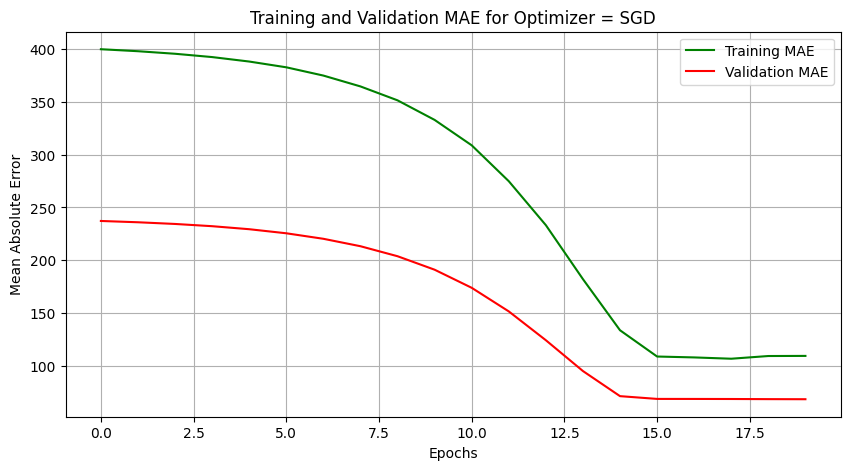

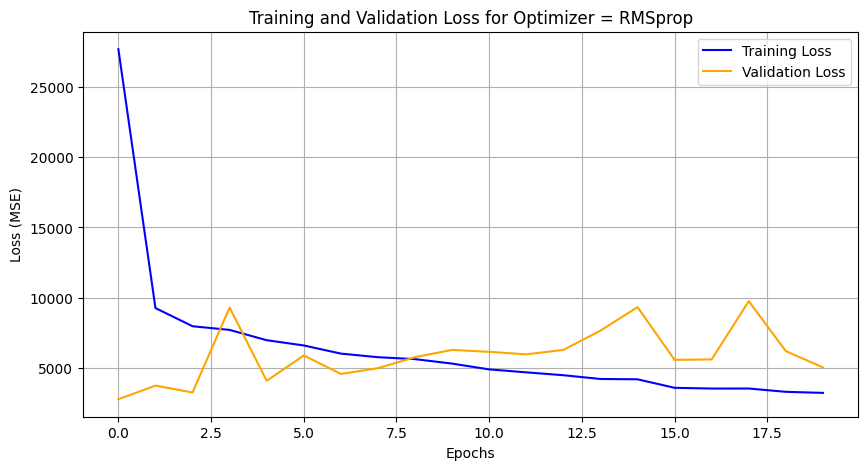

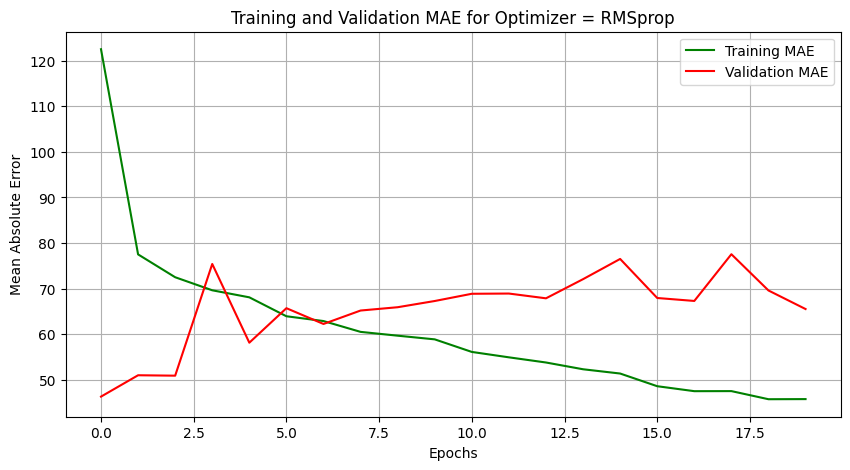

In [16]:
import matplotlib.pyplot as plt

# Histories and corresponding optimizers
opt_histories = [history_opt_adam, history_opt_sgd, history_opt_rmsprop]
optimizers = ['Adam', 'SGD', 'RMSprop']

for history, opt in zip(opt_histories, optimizers):
    # Plot: Loss (Training + Validation)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for Optimizer = {opt}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE if tracked
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE for Optimizer = {opt}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for Optimizer = {opt}.")


In [17]:
y_pred_sgd = model_opt_sgd.predict(X_test_tcn).flatten()
if np.isnan(y_pred_sgd).any():
    print("⚠️ model_opt_sgd produced NaN predictions. Likely due to unstable training. Try lowering the learning rate.")
else:
    evaluate_model(model_opt_sgd, X_test_tcn, y_test, name="TCN Model (Optimizer = SGD)")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
📊 TCN Model (Optimizer = SGD) Metrics:
 - R²:   0.3517
 - RMSE: 86.8744
 - MAE:  71.6867
 - MAPE: 33.85%



In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate TCN models with different optimizers
evaluate_model(model_opt_adam, X_test_tcn, y_test, name="TCN Model (Optimizer = Adam)")
evaluate_model(model_opt_sgd, X_test_tcn, y_test, name="TCN Model (Optimizer = SGD)")
evaluate_model(model_opt_rmsprop, X_test_tcn, y_test, name="TCN Model (Optimizer = RMSprop)")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
📊 TCN Model (Optimizer = Adam) Metrics:
 - R²:   0.7526
 - RMSE: 53.6649
 - MAE:  40.9890
 - MAPE: 28.02%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
📊 TCN Model (Optimizer = SGD) Metrics:
 - R²:   0.3517
 - RMSE: 86.8744
 - MAE:  71.6867
 - MAPE: 33.85%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
📊 TCN Model (Optimizer = RMSprop) Metrics:
 - R²:   0.5747
 - RMSE: 70.3595
 - MAE:  62.4253
 - MAPE: 37.11%



**Adam works best**

#Loss Function

**MSE**

In [20]:
model_loss_mse = Sequential()
model_loss_mse.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                       nb_filters=64,
                       kernel_size=5,
                       dilations=[1, 2, 4, 8, 16, 32],
                       activation='relu',
                       dropout_rate=0.2,
                       padding='causal',
                       return_sequences=False))
model_loss_mse.add(Dense(1))
model_loss_mse.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_loss_mse = model_loss_mse.fit(X_train_tcn, y_train,
                                      validation_data=(X_val_tcn, y_val),
                                      epochs=20, batch_size=16, verbose=1)



/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 49957.2852 - mae: 181.2945 - val_loss: 3928.3420 - val_mae: 55.5383
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 7924.8560 - mae: 72.4014 - val_loss: 5918.6484 - val_mae: 70.0726
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 5329.6465 - mae: 58.7290 - val_loss: 5545.1509 - val_mae: 67.8265
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5500.6167 - mae: 59.8876 - val_loss: 7475.6763 - val_mae: 70.1450
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2385.6594 - mae: 39.2428 - val_loss: 8960.1553 - val_mae: 80.1504
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2759.0979 - mae: 42.5570 - val_loss: 5804.9771 - val_mae: 66.0129
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2030.8655 - mae: 36.4930 - val_loss: 3976.1167 - val_mae: 57.1168
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1516.1423 - mae: 30.4888 - val_loss: 6566.0229 - val_mae: 66.93

**MAE**

In [21]:
model_loss_mae = Sequential()
model_loss_mae.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                       nb_filters=64,
                       kernel_size=5,
                       dilations=[1, 2, 4, 8, 16, 32],
                       activation='relu',
                       dropout_rate=0.2,
                       padding='causal',
                       return_sequences=False))
model_loss_mae.add(Dense(1))
model_loss_mae.compile(optimizer=Adam(learning_rate=0.01), loss='mae', metrics=['mae'])

history_loss_mae = model_loss_mae.fit(X_train_tcn, y_train,
                                      validation_data=(X_val_tcn, y_val),
                                      epochs=20, batch_size=16, verbose=1)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 188.8139 - mae: 188.8139 - val_loss: 54.1642 - val_mae: 54.1642
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 81.6957 - mae: 81.6957 - val_loss: 66.7536 - val_mae: 66.7536
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 67.0259 - mae: 67.0259 - val_loss: 67.7247 - val_mae: 67.7247
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 55.7051 - mae: 55.7051 - val_loss: 73.6481 - val_mae: 73.6481
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 51.0869 - mae: 51.0869 - val_loss: 73.2614 - val_mae: 73.2614
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 45.0810 - mae: 45.0810 - val_loss: 63.9425 - val_mae: 63.9425
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 49.0597 - mae: 49.0597 - val_loss: 66.9759 - val_mae: 66.9759
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 40.6240 - mae: 40.6240 - val_loss: 86.5610 - val_mae: 86.5610
Epoch 9/20
87/87 ━━━━━━━━━━━━

**HUBER**

In [23]:
model_loss_huber = Sequential()
model_loss_huber.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                         nb_filters=64,
                         kernel_size=5,
                         dilations=[1, 2, 4, 8, 16, 32],
                         activation='relu',
                         dropout_rate=0.2,
                         padding='causal',
                         return_sequences=False))
model_loss_huber.add(Dense(1))
model_loss_huber.compile(optimizer=Adam(learning_rate=0.001), loss='huber', metrics=['mae'])

history_loss_huber = model_loss_huber.fit(X_train_tcn, y_train,
                                          validation_data=(X_val_tcn, y_val),
                                          epochs=20, batch_size=16, verbose=1)




Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 303.9983 - mae: 304.4979 - val_loss: 53.6201 - val_mae: 54.1179
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 77.0878 - mae: 77.5866 - val_loss: 54.6713 - val_mae: 55.1688
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 71.1870 - mae: 71.6843 - val_loss: 52.1923 - val_mae: 52.6918
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 65.8723 - mae: 66.3700 - val_loss: 63.2351 - val_mae: 63.7348
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 78.6284 - mae: 79.1271 - val_loss: 59.2641 - val_mae: 59.7628
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 60.8253 - mae: 61.3242 - val_loss: 60.5849 - val_mae: 61.0849
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 58.6887 - mae: 59.1861 - val_loss: 62.1385 - val_mae: 62.6385
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 52.1504 - mae: 52.6479 - val_loss: 66.2841 - val_mae: 66.7828
Epoch 9/20
87/87 ━━━━━━━━━━━━

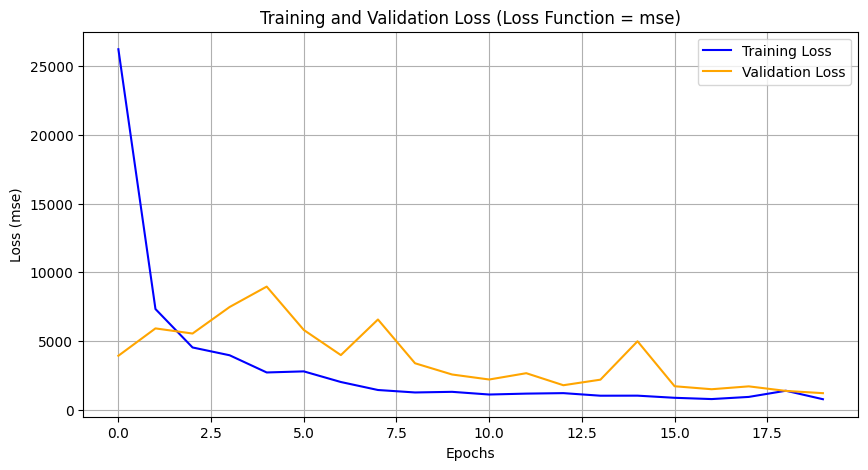

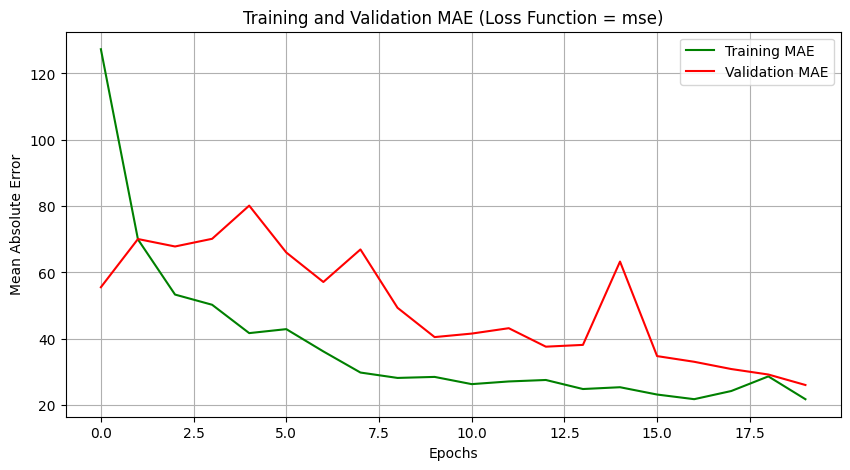

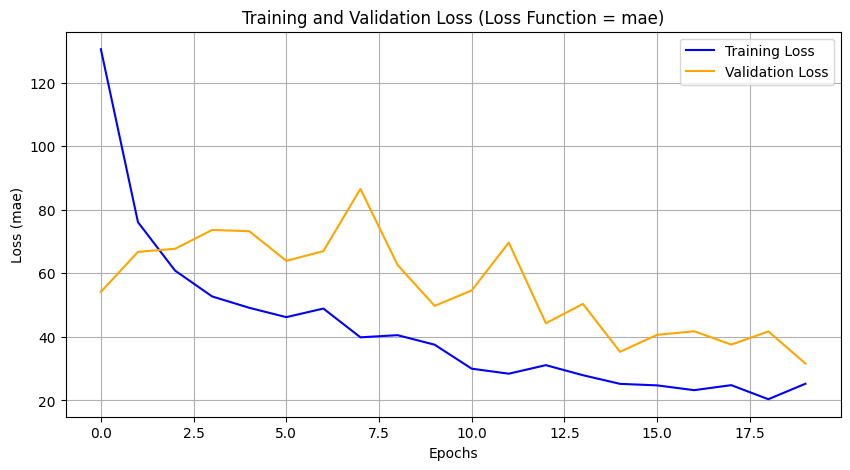

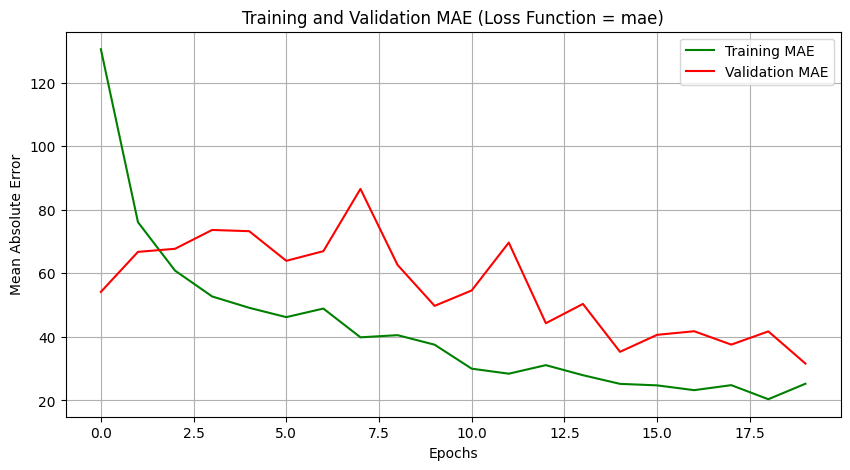

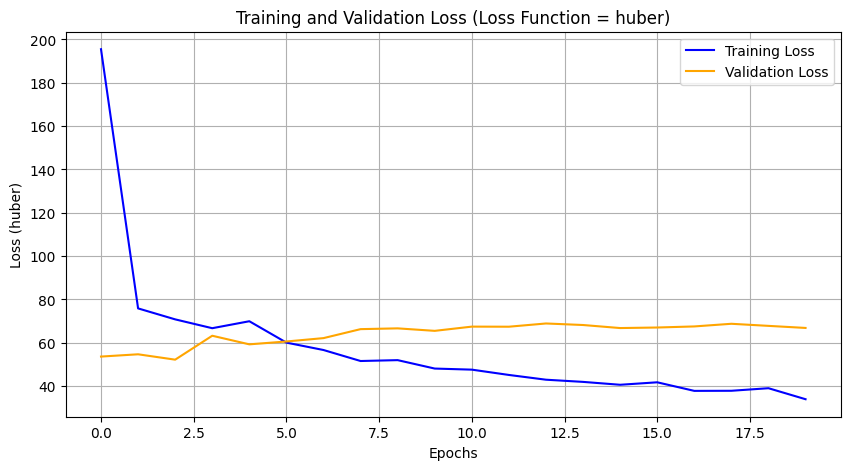

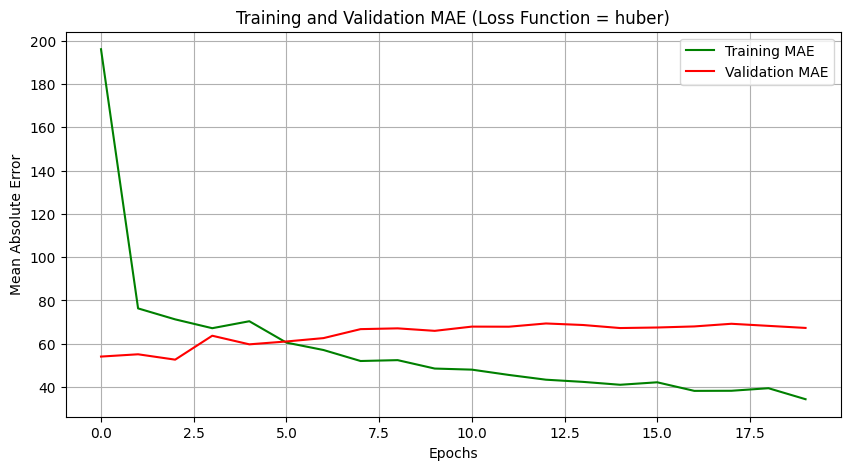

In [24]:
import matplotlib.pyplot as plt

# List of training histories and corresponding loss functions
loss_histories = [history_loss_mse,history_loss_mae, history_loss_huber]
loss_functs = ["mse","mae", "huber"]  # Corresponding loss functions used

for history, loss in zip(loss_histories, loss_functs):
    # Plot: Training & Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss (Loss Function = {loss})')
    plt.xlabel('Epochs')
    plt.ylabel(f'Loss ({loss})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: Training & Validation MAE if available
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE (Loss Function = {loss})')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for Loss Function = {loss}. Add `metrics=['mae']` during compile.")


In [25]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate TCN models with different loss functions
evaluate_model(model_loss_mse, X_test_tcn, y_test, name="TCN Model (Loss = mse)")
evaluate_model(model_loss_mae, X_test_tcn, y_test, name="TCN Model (Loss = mae)")
evaluate_model(model_loss_huber, X_test_tcn, y_test, name="TCN Model (Loss = huber)")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
📊 TCN Model (Loss = mse) Metrics:
 - R²:   0.8426
 - RMSE: 42.8039
 - MAE:  24.7649
 - MAPE: 18.03%

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step
📊 TCN Model (Loss = mae) Metrics:
 - R²:   0.8424
 - RMSE: 42.8377
 - MAE:  27.4842
 - MAPE: 18.49%

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
📊 TCN Model (Loss = huber) Metrics:
 - R²:   0.5134
 - RMSE: 75.2596
 - MAE:  66.1507
 - MAPE: 42.50%



**MSE is better**

#Epoch

**epoch = 20**

In [26]:
model_epochs_20 = Sequential()
model_epochs_20.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                        nb_filters=64,
                        kernel_size=5,
                        dilations=[1, 2, 4, 8, 16, 32],
                        activation='relu',
                        dropout_rate=0.2,
                        padding='causal',
                        return_sequences=False))
model_epochs_20.add(Dense(1))
model_epochs_20.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_epochs_20 = model_epochs_20.fit(X_train_tcn, y_train,
                                        validation_data=(X_val_tcn, y_val),
                                        epochs=20, batch_size=16, verbose=1)


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 37146.3359 - mae: 144.2607 - val_loss: 4400.7344 - val_mae: 59.6556
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 7223.8345 - mae: 69.0189 - val_loss: 6249.2959 - val_mae: 67.8586
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 4161.2095 - mae: 52.6393 - val_loss: 5607.9790 - val_mae: 63.9113
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2902.3801 - mae: 42.8710 - val_loss: 4797.7393 - val_mae: 62.4428
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 2254.7356 - mae: 37.8616 - val_loss: 5295.2334 - val_mae: 60.5402
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 2372.1465 - mae: 38.9125 - val_loss: 4215.1201 - val_mae: 56.8714
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1723.9167 - mae: 33.0775 - val_loss: 6329.0571 - val_mae: 64.7060
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1540.2378 - mae: 31.1081 - val_loss: 5496.1333 - val_mae: 59.71

**epoch = 50**

In [27]:
model_epochs_50 = Sequential()
model_epochs_50.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                        nb_filters=64,
                        kernel_size=5,
                        dilations=[1, 2, 4, 8, 16, 32],
                        activation='relu',
                        dropout_rate=0.2,
                        padding='causal',
                        return_sequences=False))
model_epochs_50.add(Dense(1))
model_epochs_50.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_epochs_50 = model_epochs_50.fit(X_train_tcn, y_train,
                                        validation_data=(X_val_tcn, y_val),
                                        epochs=50, batch_size=16, verbose=1)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 59513.4297 - mae: 197.6578 - val_loss: 3891.1487 - val_mae: 54.3104
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7029.2681 - mae: 68.3408 - val_loss: 8176.3022 - val_mae: 75.5991
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 4803.3032 - mae: 56.3153 - val_loss: 11476.2930 - val_mae: 88.0432
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4658.4614 - mae: 54.5345 - val_loss: 6552.6787 - val_mae: 66.5340
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2592.2205 - mae: 41.7245 - val_loss: 11509.0771 - val_mae: 94.0121
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2898.5295 - mae: 43.3226 - val_loss: 4953.6499 - val_mae: 59.5002
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2285.2432 - mae: 38.4877 - val_loss: 2992.2856 - val_mae: 50.9858
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1674.6329 - mae: 32.2856 - val_loss: 2787.8030 - val_mae: 48.6

**epoch = 100**

In [28]:
model_epochs_100 = Sequential()
model_epochs_100.add(TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                         nb_filters=64,
                         kernel_size=5,
                         dilations=[1, 2, 4, 8, 16, 32],
                         activation='relu',
                         dropout_rate=0.2,
                         padding='causal',
                         return_sequences=False))
model_epochs_100.add(Dense(1))
model_epochs_100.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history_epochs_100 = model_epochs_100.fit(X_train_tcn, y_train,
                                          validation_data=(X_val_tcn, y_val),
                                          epochs=100, batch_size=16, verbose=1)


Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 38719.4961 - mae: 147.4082 - val_loss: 4627.0581 - val_mae: 58.5213
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6766.9312 - mae: 66.0151 - val_loss: 5183.7275 - val_mae: 65.0444
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5031.6479 - mae: 56.8667 - val_loss: 6196.1626 - val_mae: 67.3380
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3497.9512 - mae: 47.1151 - val_loss: 6181.0273 - val_mae: 66.6971
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1995.6836 - mae: 35.6467 - val_loss: 7484.0659 - val_mae: 69.5363
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2071.0239 - mae: 36.8119 - val_loss: 4339.0791 - val_mae: 59.7376
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2052.3997 - mae: 35.6828 - val_loss: 3780.9600 - val_mae: 53.0894
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1230.8370 - mae: 28.1928 - val_loss: 4499.9175 - val_mae

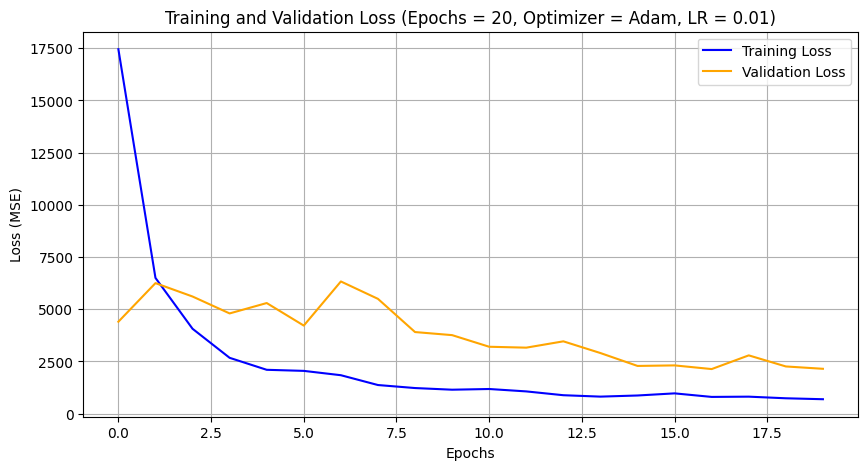

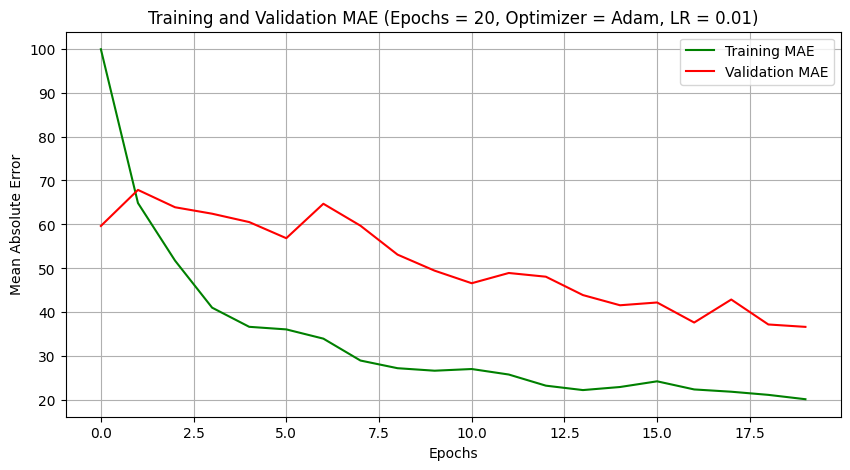

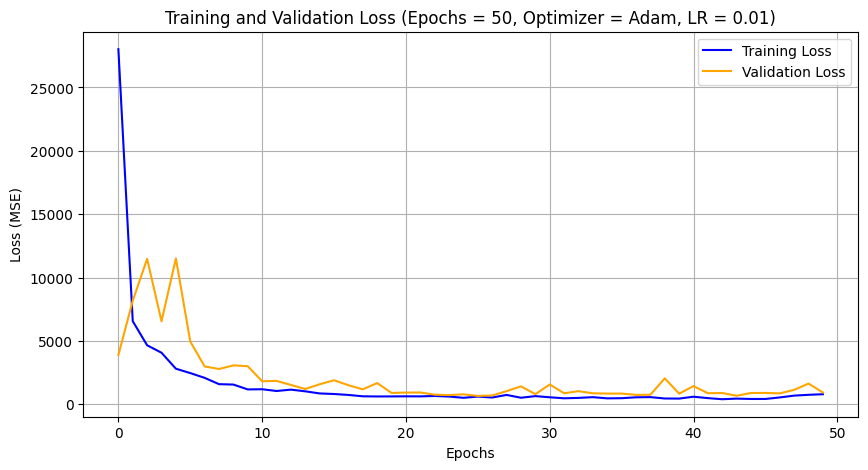

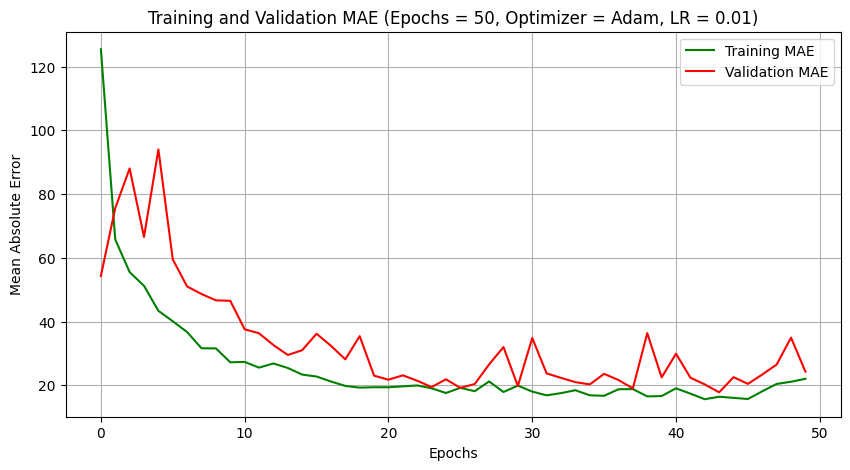

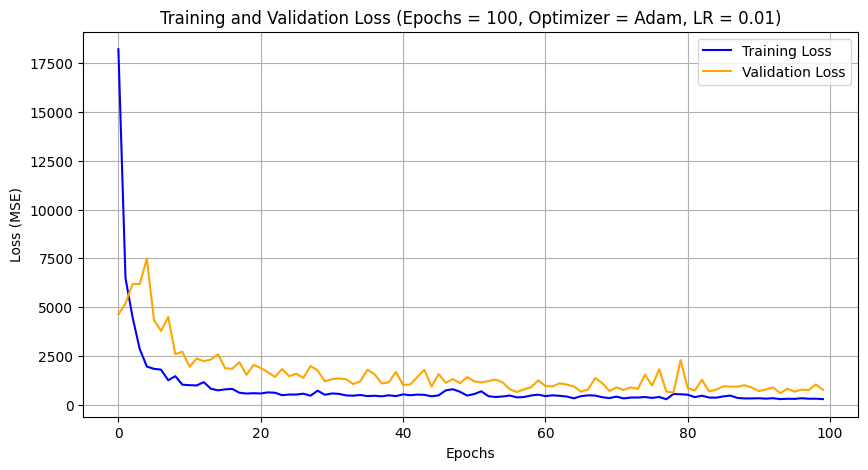

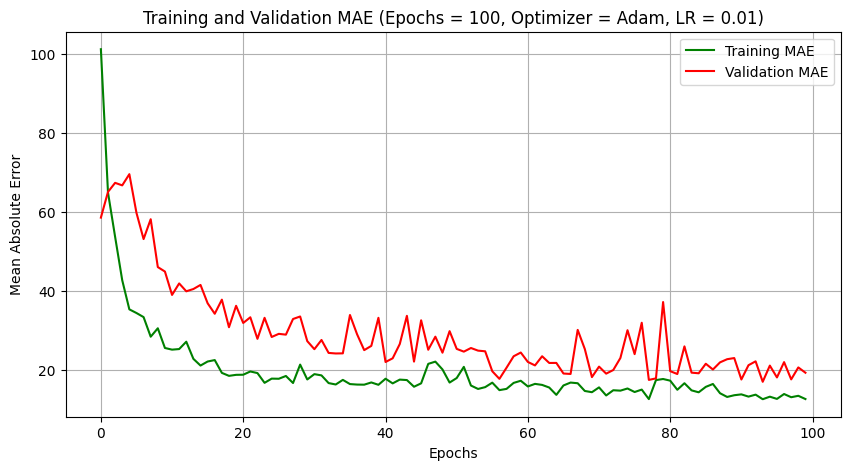

In [29]:
import matplotlib.pyplot as plt

# List of histories and corresponding epoch counts
epoch_histories = [history_epochs_20,history_epochs_50, history_epochs_100]
epoch_counts = [20,50, 100]  # Actual epoch values used during training

for history, n in zip(epoch_histories, epoch_counts):
    # Plot: Loss (Training + Validation)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss (Epochs = {n}, Optimizer = Adam, LR = 0.01)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE if tracked
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE (Epochs = {n}, Optimizer = Adam, LR = 0.01)')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for Epochs = {n}. Add `metrics=['mae']` during compile.")

In [30]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate TCN models with different loss functions
evaluate_model(model_epochs_20, X_test_tcn, y_test, name="TCN Model (epoch = 20)")
evaluate_model(model_epochs_50, X_test_tcn, y_test, name="TCN Model (epoch = 50)")
evaluate_model(model_epochs_100, X_test_tcn, y_test, name="TCN Model (epoch = 100)")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
📊 TCN Model (epoch = 20) Metrics:
 - R²:   0.7769
 - RMSE: 50.9660
 - MAE:  34.7030
 - MAPE: 25.23%

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
📊 TCN Model (epoch = 50) Metrics:
 - R²:   0.8804
 - RMSE: 37.3111
 - MAE:  19.6933
 - MAPE: 12.99%

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
📊 TCN Model (epoch = 100) Metrics:
 - R²:   0.8843
 - RMSE: 36.6968
 - MAE:  15.4160
 - MAPE: 10.57%



**epoch 50 works best , epoch 100 may be overfitting**

#batch size


**size = 16**

In [6]:
model_bs16 = Sequential()
model_bs16.add(
    TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
        nb_filters=64,
        kernel_size=5,
        dilations=[1, 2, 4, 8, 16, 32],
        activation='relu',
        dropout_rate=0.2,
        padding='causal',
        return_sequences=False)
)
model_bs16.add(Dense(1))

optimizer = Adam(learning_rate=0.01)
model_bs16.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history_bs16 = model_bs16.fit(X_train_tcn, y_train,
                              validation_data=(X_val_tcn, y_val),
                              epochs=50,
                              batch_size=16,
                              verbose=1)


Epoch 1/50
87/87 [==============================] - 7s 25ms/step - loss: 22754.3516 - mae: 113.7233 - val_loss: 4027.3413 - val_mae: 56.0203
Epoch 2/50
87/87 [==============================] - 2s 18ms/step - loss: 5891.6875 - mae: 62.0895 - val_loss: 6327.0884 - val_mae: 67.4511
Epoch 3/50
87/87 [==============================] - 2s 18ms/step - loss: 3666.3264 - mae: 48.7257 - val_loss: 9716.5938 - val_mae: 82.1164
Epoch 4/50
87/87 [==============================] - 2s 23ms/step - loss: 3665.6182 - mae: 49.2433 - val_loss: 7341.0532 - val_mae: 70.9280
Epoch 5/50
87/87 [==============================] - 2s 27ms/step - loss: 2444.9111 - mae: 39.4063 - val_loss: 4498.4766 - val_mae: 58.6596
Epoch 6/50
87/87 [==============================] - 2s 19ms/step - loss: 1474.0989 - mae: 30.4156 - val_loss: 4437.4751 - val_mae: 58.1023
Epoch 7/50
87/87 [==============================] - 2s 19ms/step - loss: 1559.6329 - mae: 31.2744 - val_loss: 3291.5388 - val_mae: 52.6051
Epoch 8/50
87/87 [=======

**size = 32**

In [9]:
model_bs32 = Sequential()
model_bs32.add(
    TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
        nb_filters=64,
        kernel_size=5,
        dilations=[1, 2, 4, 8, 16, 32],
        activation='relu',
        dropout_rate=0.2,
        padding='causal',
        return_sequences=False)
)
model_bs32.add(Dense(1))
optimizer = Adam(learning_rate=0.01)
model_bs32.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history_bs32 = model_bs32.fit(X_train_tcn, y_train,
                              validation_data=(X_val_tcn, y_val),
                              epochs=50,
                              batch_size=32,
                              verbose=1)


Epoch 1/50
44/44 [==============================] - 10s 46ms/step - loss: 31149.2188 - mae: 135.2432 - val_loss: 3424.4736 - val_mae: 51.2807
Epoch 2/50
44/44 [==============================] - 2s 48ms/step - loss: 6833.6318 - mae: 67.6556 - val_loss: 5388.9414 - val_mae: 62.8078
Epoch 3/50
44/44 [==============================] - 1s 30ms/step - loss: 7680.0854 - mae: 68.9458 - val_loss: 5263.1899 - val_mae: 62.4356
Epoch 4/50
44/44 [==============================] - 3s 68ms/step - loss: 5092.4189 - mae: 57.9104 - val_loss: 6925.6968 - val_mae: 68.0157
Epoch 5/50
44/44 [==============================] - 3s 57ms/step - loss: 3746.3660 - mae: 49.0712 - val_loss: 4549.9180 - val_mae: 59.7354
Epoch 6/50
44/44 [==============================] - 2s 41ms/step - loss: 4157.2349 - mae: 52.0712 - val_loss: 4641.5464 - val_mae: 61.2463
Epoch 7/50
44/44 [==============================] - 1s 32ms/step - loss: 2490.1777 - mae: 40.1624 - val_loss: 10243.3076 - val_mae: 91.9198
Epoch 8/50
44/44 [=====

**size = 48**

In [10]:
model_bs48 = Sequential()
model_bs48.add(
    TCN(input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
        nb_filters=64,
        kernel_size=5,
        dilations=[1, 2, 4, 8, 16, 32],
        activation='relu',
        dropout_rate=0.2,
        padding='causal',
        return_sequences=False)
)
model_bs48.add(Dense(1))
optimizer = Adam(learning_rate=0.01)
model_bs48.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history_bs48 = model_bs48.fit(X_train_tcn, y_train,
                              validation_data=(X_val_tcn, y_val),
                              epochs=50,
                              batch_size=48,
                              verbose=1)


Epoch 1/50
29/29 [==============================] - 7s 60ms/step - loss: 34735.6211 - mae: 145.6119 - val_loss: 2685.9521 - val_mae: 45.6796
Epoch 2/50
29/29 [==============================] - 1s 44ms/step - loss: 7854.2153 - mae: 72.3889 - val_loss: 4434.0312 - val_mae: 56.6682
Epoch 3/50
29/29 [==============================] - 1s 42ms/step - loss: 9734.8740 - mae: 79.3045 - val_loss: 4702.3315 - val_mae: 62.5951
Epoch 4/50
29/29 [==============================] - 1s 43ms/step - loss: 5354.7725 - mae: 59.3794 - val_loss: 5036.4214 - val_mae: 64.3881
Epoch 5/50
29/29 [==============================] - 1s 44ms/step - loss: 3849.8901 - mae: 50.1473 - val_loss: 6069.7075 - val_mae: 66.0339
Epoch 6/50
29/29 [==============================] - 1s 43ms/step - loss: 3838.4634 - mae: 50.4324 - val_loss: 7791.8755 - val_mae: 72.7198
Epoch 7/50
29/29 [==============================] - 1s 52ms/step - loss: 3073.2869 - mae: 44.1820 - val_loss: 6581.9238 - val_mae: 67.3127
Epoch 8/50
29/29 [=======

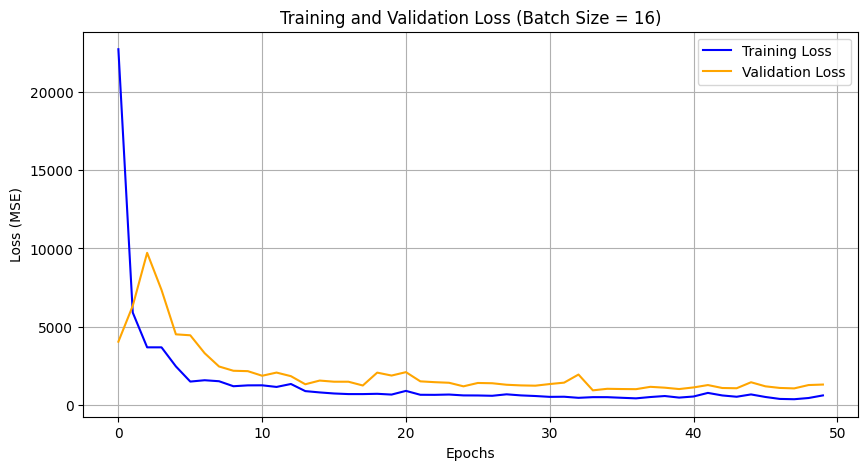

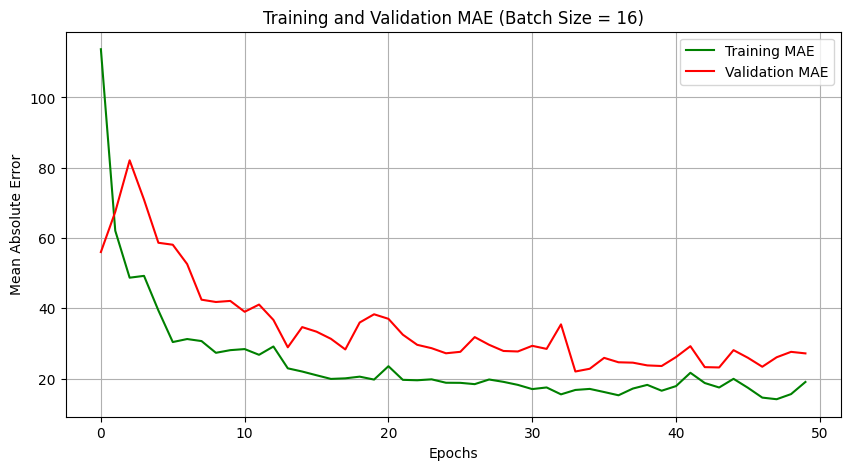

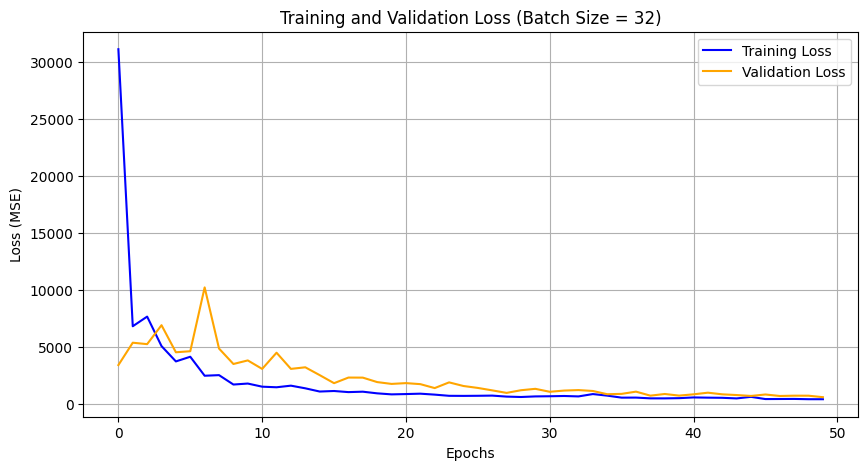

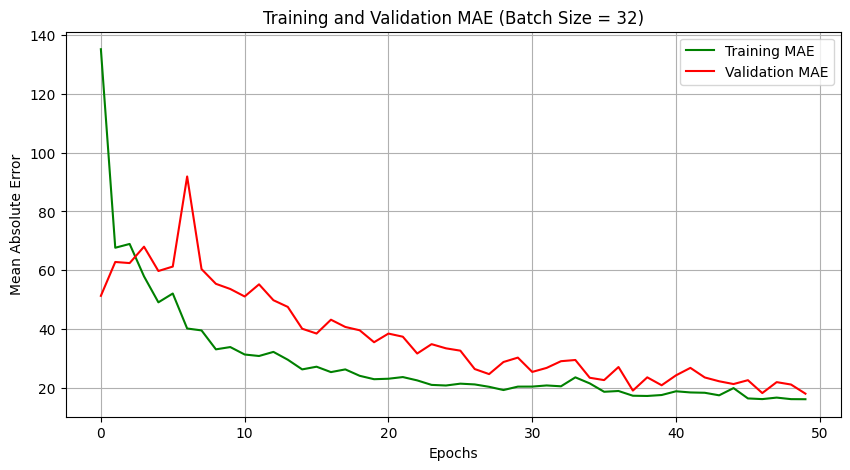

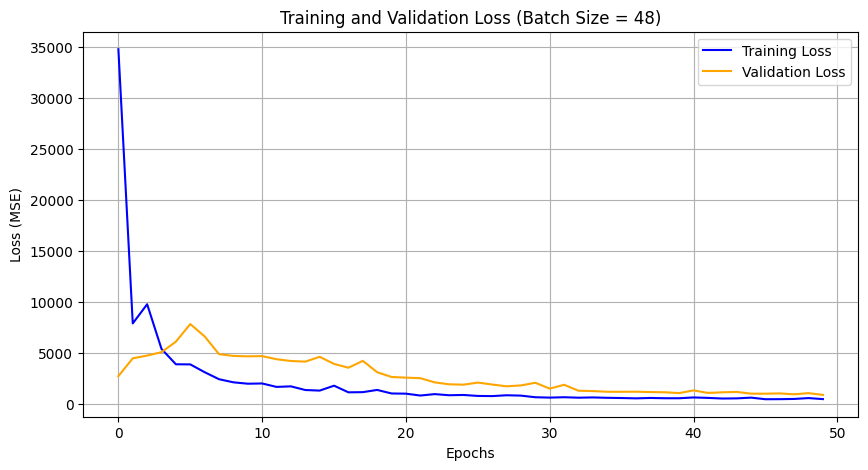

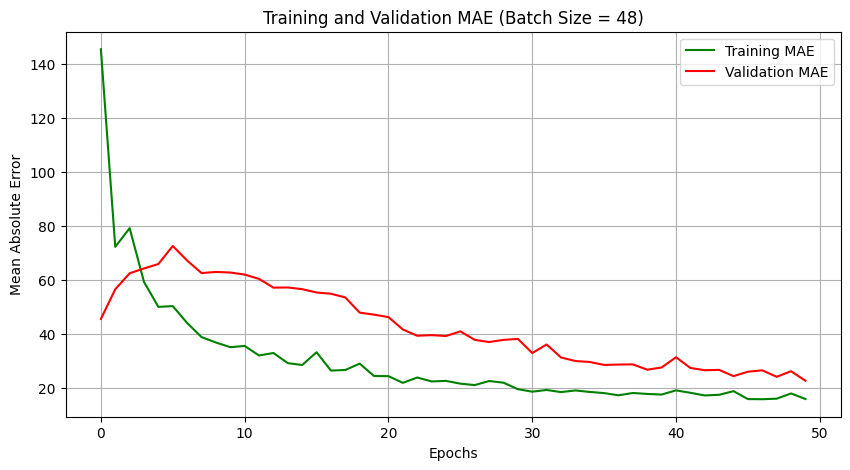

In [11]:
import matplotlib.pyplot as plt

# List of histories and corresponding batch sizes
batch_histories = [history_bs16, history_bs32, history_bs48]
batch_sizes = [16, 32, 48]  # Match with your actual batch sizes

for history, b in zip(batch_histories, batch_sizes):
    # Plot: Loss (Training + Validation)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss (Batch Size = {b})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot: MAE if tracked
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE', color='green')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'Training and Validation MAE (Batch Size = {b})')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ MAE metric not available for Batch Size = {b}. Add `metrics=['mae']` during compile.")

In [12]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-10))) * 100

    print(f"📊 {name} Metrics:")
    print(f" - R²:   {r2:.4f}")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - MAE:  {mae:.4f}")
    print(f" - MAPE: {mape:.2f}%\n")

# Evaluate all three models with their respective test sets
evaluate_model(model_bs16, X_test_tcn, y_test, name="TCN Model (Batch Size = 16)")
evaluate_model(model_bs32, X_test_tcn, y_test, name="TCN Model (Batch Size = 32)")
evaluate_model(model_bs48, X_test_tcn, y_test, name="TCN Model (Batch Size = 48)")


7/7 [==============================] - 1s 9ms/step
📊 TCN Model (Batch Size = 16) Metrics:
 - R²:   0.8375
 - RMSE: 43.4933
 - MAE:  25.7302
 - MAPE: 18.97%

7/7 [==============================] - 1s 12ms/step
📊 TCN Model (Batch Size = 32) Metrics:
 - R²:   0.8883
 - RMSE: 36.0647
 - MAE:  15.9716
 - MAPE: 10.41%

7/7 [==============================] - 1s 11ms/step
📊 TCN Model (Batch Size = 48) Metrics:
 - R²:   0.8674
 - RMSE: 39.2811
 - MAE:  20.8178
 - MAPE: 14.54%



**32 is best batch size**

Base Model Hyperparameters

- Number of Residual Blocks: Determined implicitly by the dilation rates [1, 2, 4, 8, 16, 32] , representing 6 residual blocks.
- Number of Filters per Layer: 64, defining the feature extraction capacity.
- Kernel Size: 5, affecting the receptive field size.
- Dilation Rate: [1, 2, 4, 8, 16 32], enabling modeling of long-range dependencies.
- Dropout Rate: 0.2, used to prevent overfitting.
- Learning Rate: 0.01, step size for the Adam optimizer.
- Loss Function: Mean Squared Error ('mse'), suited for regression tasks.
- Batch Size: 32
- Epoch: 50